In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/hpc-rosneft/drigo/surrogate/src/')
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error as mse

from dataset import load_variable_years
from _main import Main
from tools import Logger

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib notebook 

from netcdftools import MyNetCDF

In [2]:
log = Logger(to_file=False, silent=False)
results_df = pd.DataFrame(columns = ['Point','dx','dy','dt', 'RMSE_surrogate','RMSE_model'])
ncdf = MyNetCDF(path='data/land-exapmle-int.nc')

results = []
def rmse(pred, test):
    rmse = np.sqrt(np.nanmean((test - pred)**2))
    #todo - дописать как в статье
    
    return rmse
def coords_to_point(coords):
    from netcdftools import MyNetCDF
    ncdf = MyNetCDF(path='data/land-exapmle-int.nc')
    return list(ncdf.coords_to_index(coords)[0].data)
    
    
def plotting(pred, y_test, model_data, years_test,title=None):
    
    # plotting settings
    import matplotlib as mpl
    mpl.rcParams['figure.dpi']= 1200
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams["date.autoformatter.year"] = "%Y"
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
    fig, ax = plt.subplots()
    plt.gca().xaxis.grid(True, linestyle='--')
    
    dates = pd.date_range('01/01/{}'.format(years_test[0]), '31/12/{}'.format(years_test[-1])).to_pydatetime()

    ax.plot(dates, pred, label='Predictions')
    ax.plot(dates, y_test, label='Measurements',linewidth=2)
    ax.plot(dates, model_data, label = 'NEMO', alpha=0.8)
    
    ax.axhline(y=0, color='grey', linestyle='-')
    fig.legend()
    fig.autofmt_xdate()

    if title is not None: plt.title(title)
    plt.show()
    return plt


def regress(coords, parameters, reg_params, filters=None):
    point = coords_to_point(coords)
    model_data = load_variable_years('icethic_cea', parameters['years_test'], point)
    y_test = load_variable_years(parameters['y_var'], parameters['years_test'], point)
    
    m=Main(parameters=parameters, reg_params=reg_params, logger=log, filters=filters)
    pred = m.predict_point(point)
    
    rmse_val_pred = rmse(pred, y_test)
    rmse_val_mod = rmse(model_data, y_test)
    results_df.loc[len(results_df)+1] = [coords,
                                     reg_params['dx'],
                                     reg_params['dy'],
                                     reg_params['dt'],
                                     rmse_val_pred,
                                     rmse_val_mod]
    results.append(pred)
    print("RMSE model-measurements: {:.5f}".format(rmse_val_mod))
    print("RMSE prediction-measurements: {:.5f}".format(rmse_val_pred))
    plotting(pred, y_test, model_data, parameters['years_test'], title = '{}N {}E'.format(coords[0], coords[1]))

def rmse(pred, test):
    rmse = np.sqrt(np.nanmean((test - pred)**2))
    #todo - дописать как в статье
    
    return rmse
points = [[78,84],[80,-5],[73.6,162],[85,-180]]

results_df = pd.DataFrame(columns = ['Point','dx','dy','dt', 'RMSE_surrogate','RMSE_model'])
points = [[78,84],[80,-5],[73.6,162],[85,-180]]

from sklearn.linear_model import Lasso, Ridge

Bilding regression with different parameters for 4 points in Arctic ocean:

|Number   | Coordinates  |  Geographical object |
|---|---|---|
|  1 | [78,84]  |  Kara sea |
|  2 | 80,-5  | Fram strait  |
|  3 |  73.6,162 | East Siberian Sea  |
|  4 | 85,-180  |  Open ocean |

<img src="data/map_points.png" alt="map" style="width: 500px;"/>

# No PCA, dx=dy=dt=5

2019-08-01 13:12:29	Loading test and train data...
2019-08-01 13:12:56	Data is loaded
Using 9317 features
RMSE model-measurements: 0.37833
RMSE prediction-measurements: 0.19940


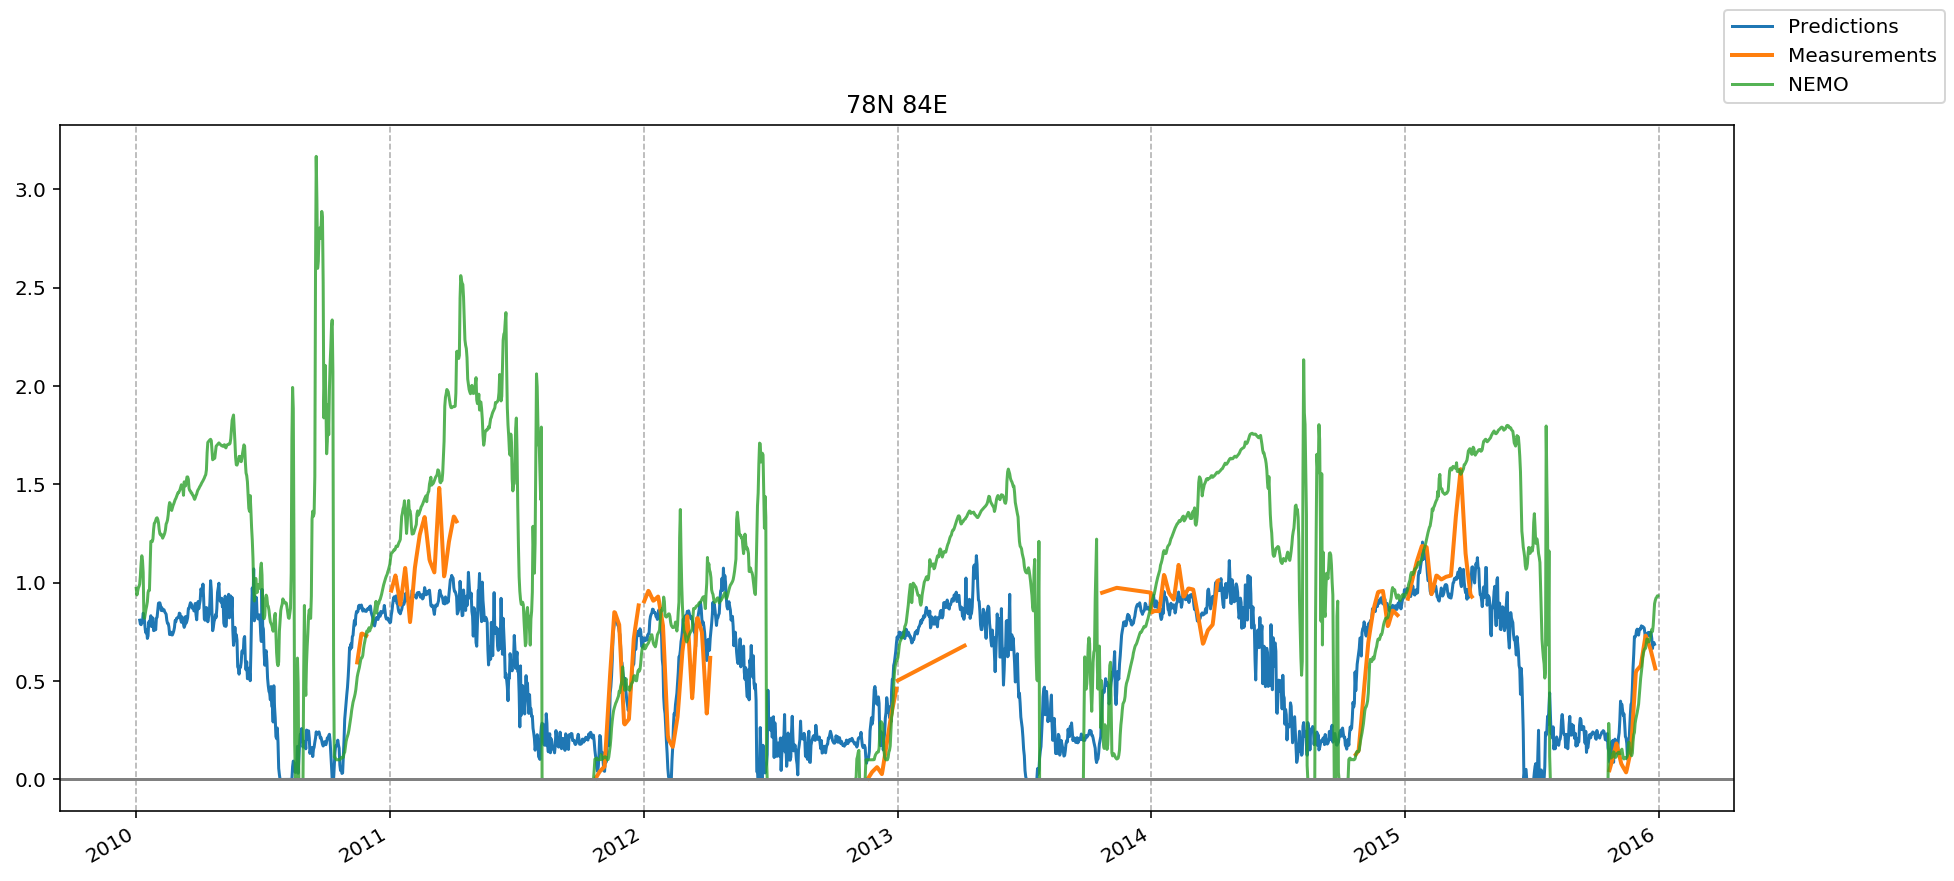

2019-08-01 13:13:15	Loading test and train data...
2019-08-01 13:13:39	Data is loaded
Using 9317 features


/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE model-measurements: 1.07631
RMSE prediction-measurements: 0.38052


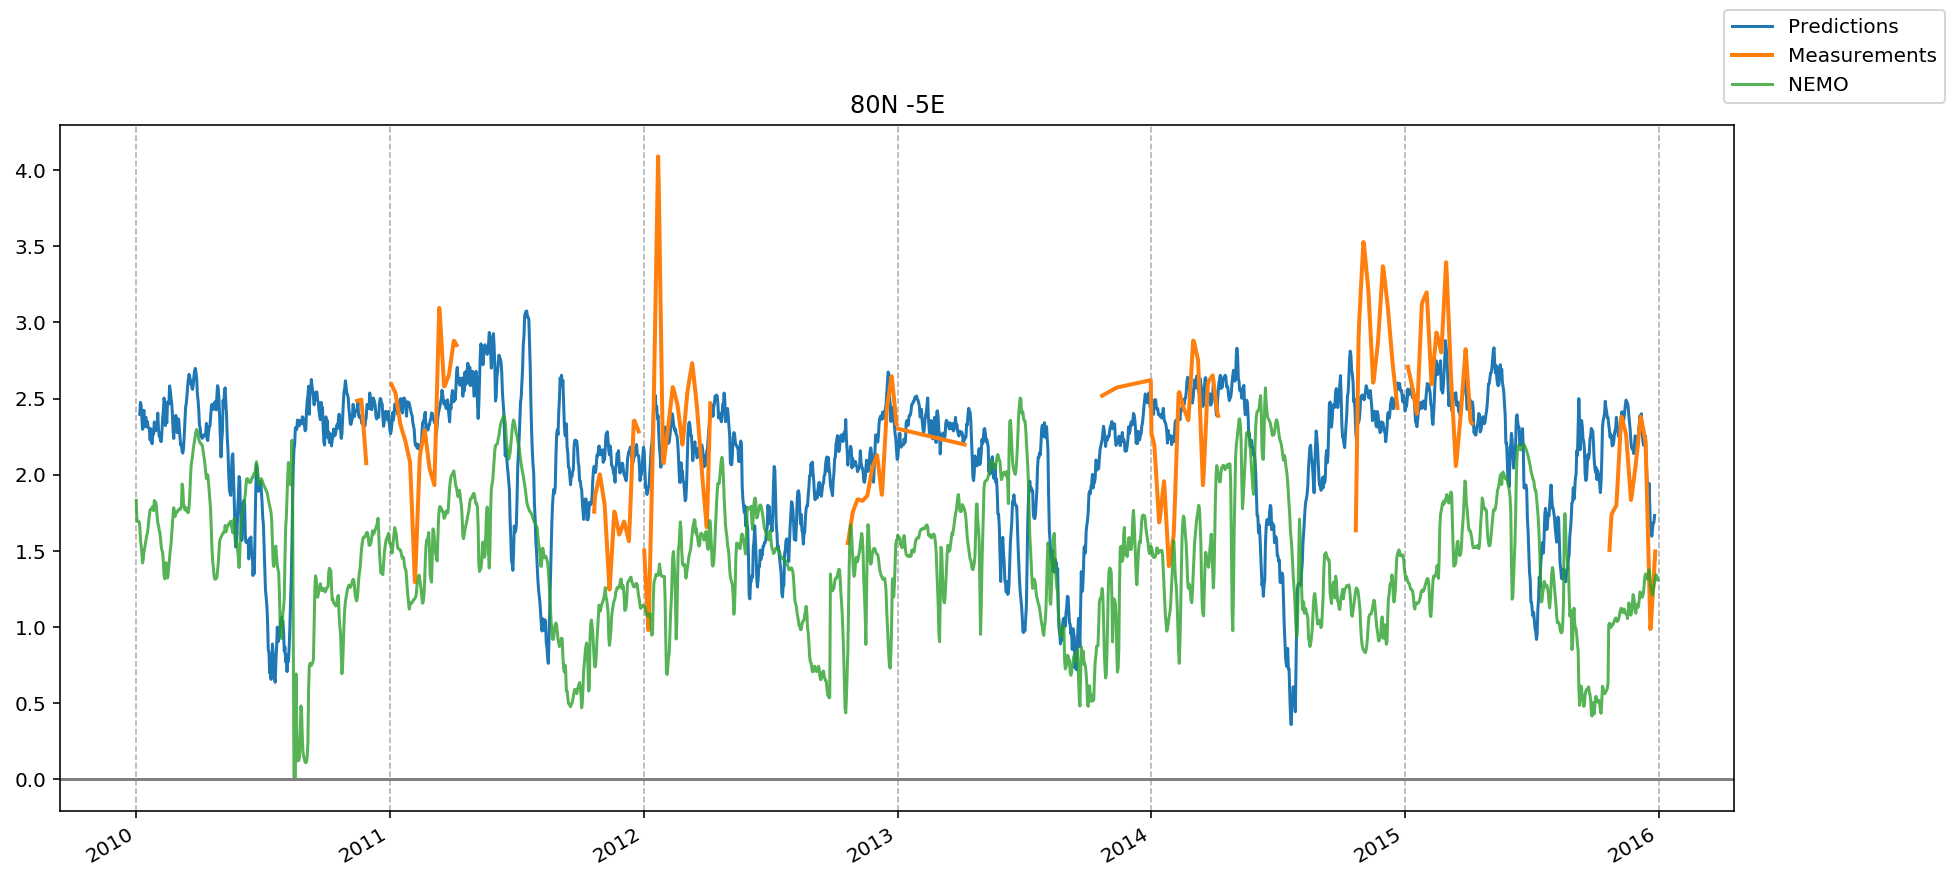

2019-08-01 13:13:53	Loading test and train data...
2019-08-01 13:14:17	Data is loaded
Using 9317 features
RMSE model-measurements: 0.46572
RMSE prediction-measurements: 0.28577


2019-08-01 13:14:30	Loading test and train data...
2019-08-01 13:14:54	Data is loaded
Using 9317 features
RMSE model-measurements: 0.46759
RMSE prediction-measurements: 0.28847


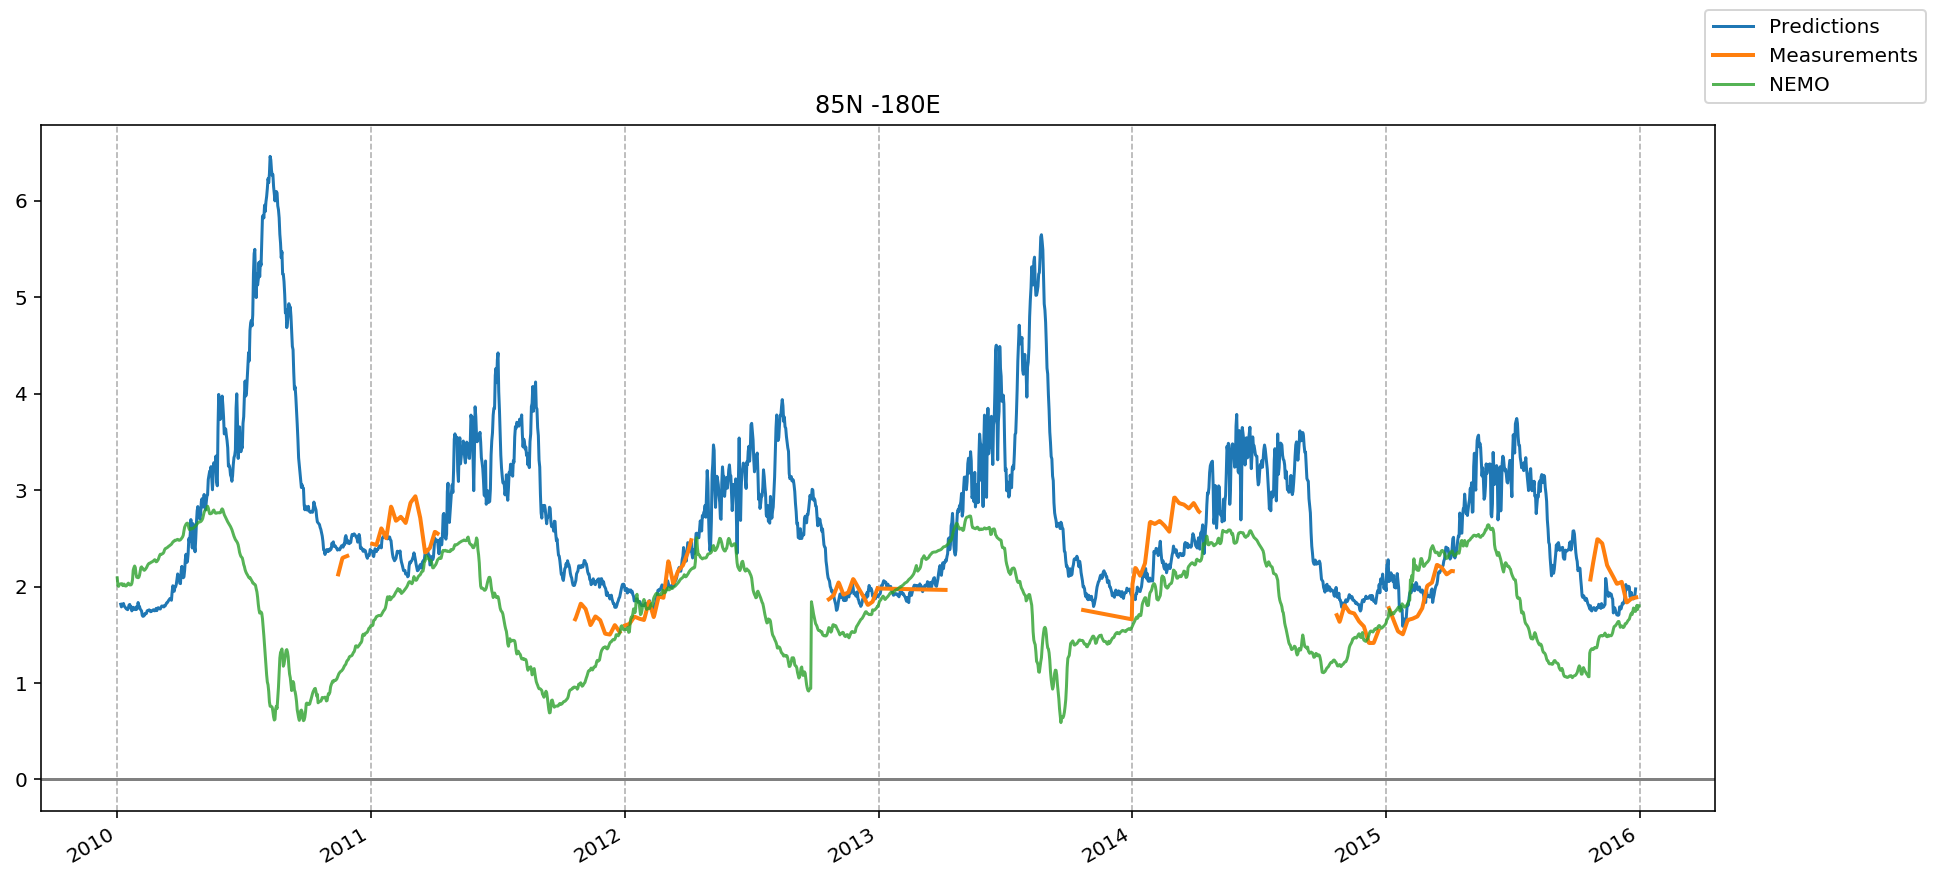

In [3]:
parameters = dict(years_train=list(range(2010, 2016)),
                  years_test=list(range(2010, 2016)),
                  #X_vars=['ice_conc', 'tair', 'votemper','vosaline','radlw','radsw'],
                  X_vars=['ice_conc','icethic_cea', 'votemper','vosaline','radlw','radsw','tair'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )
for point in points:
    regress(point, parameters, reg_params)

# PCA, dx=dy=dt=5

2019-08-01 13:15:09	Loading test and train data...
2019-08-01 13:15:33	Data is loaded
Applying PCA
Number of components for 99% explained variance: 24
Applying PCA
Number of components for 99% explained variance: 24
Using 24 features
RMSE model-measurements: 0.37833
RMSE prediction-measurements: 0.24072


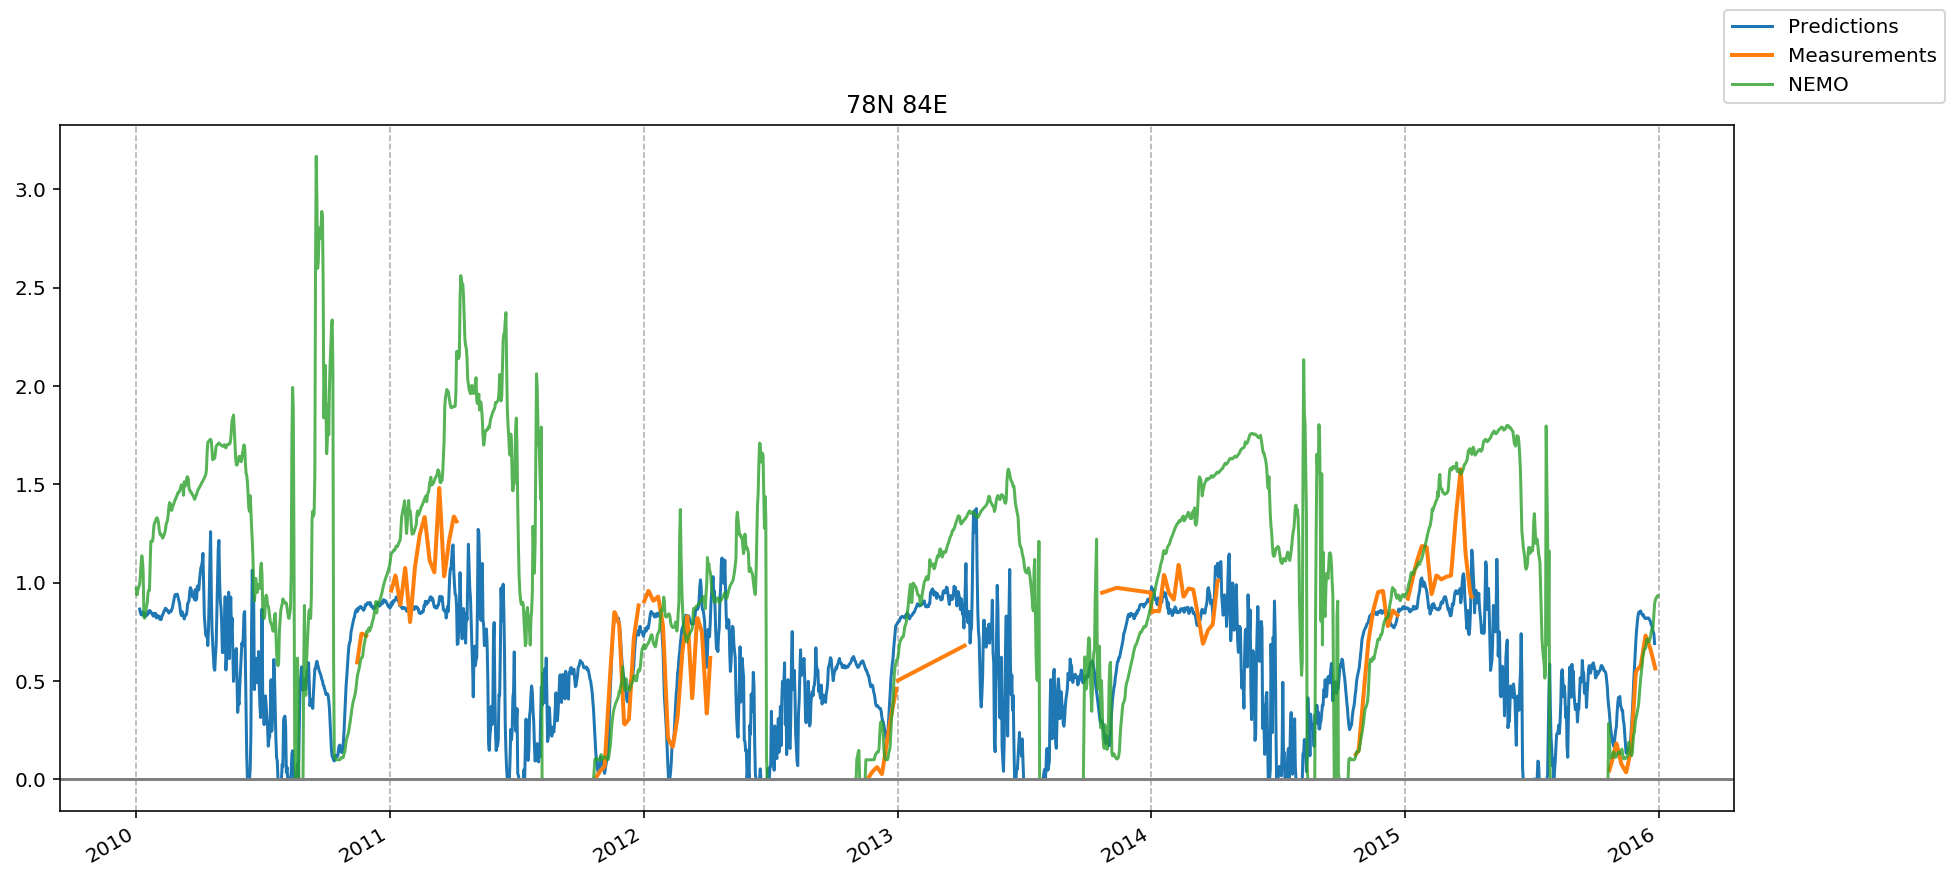

2019-08-01 13:15:46	Loading test and train data...
2019-08-01 13:16:10	Data is loaded
Applying PCA
Number of components for 99% explained variance: 29
Applying PCA
Number of components for 99% explained variance: 29
Using 29 features
RMSE model-measurements: 1.07631
RMSE prediction-measurements: 0.44839


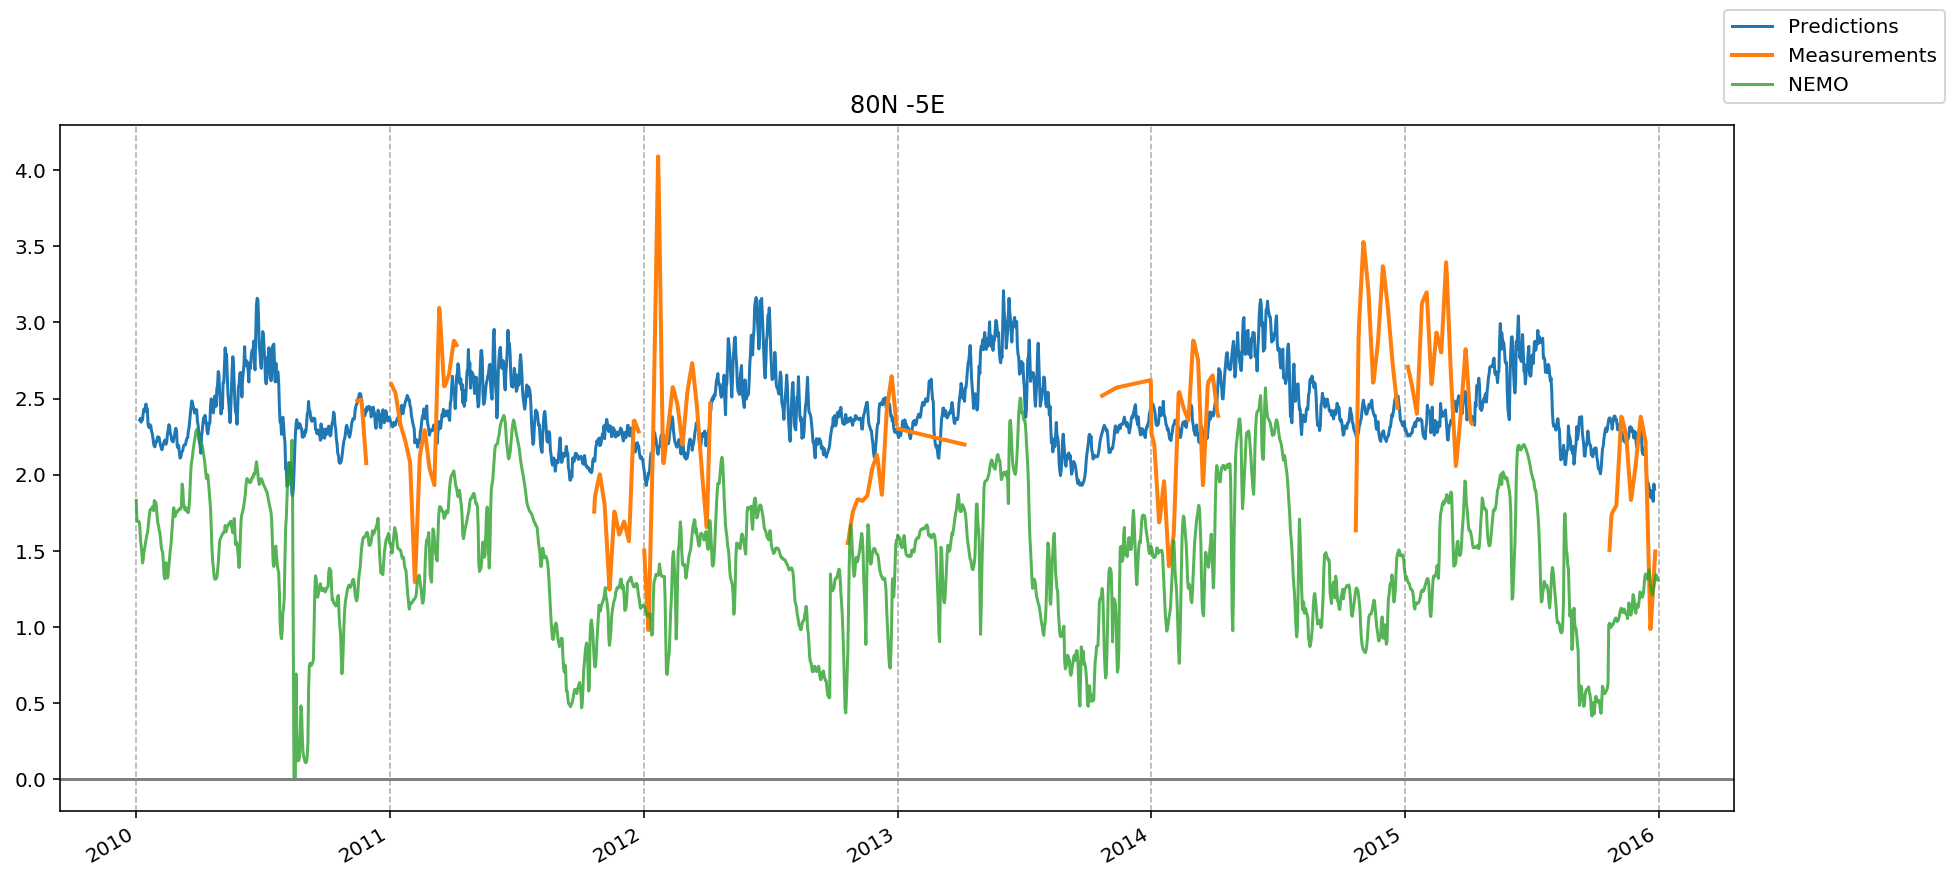

2019-08-01 13:16:22	Loading test and train data...
2019-08-01 13:16:46	Data is loaded
Applying PCA
Number of components for 99% explained variance: 23
Applying PCA
Number of components for 99% explained variance: 23
Using 23 features
RMSE model-measurements: 0.46572
RMSE prediction-measurements: 0.30402


2019-08-01 13:16:58	Loading test and train data...
2019-08-01 13:17:22	Data is loaded
Applying PCA
Number of components for 99% explained variance: 21
Applying PCA
Number of components for 99% explained variance: 21
Using 21 features
RMSE model-measurements: 0.46759
RMSE prediction-measurements: 0.31821


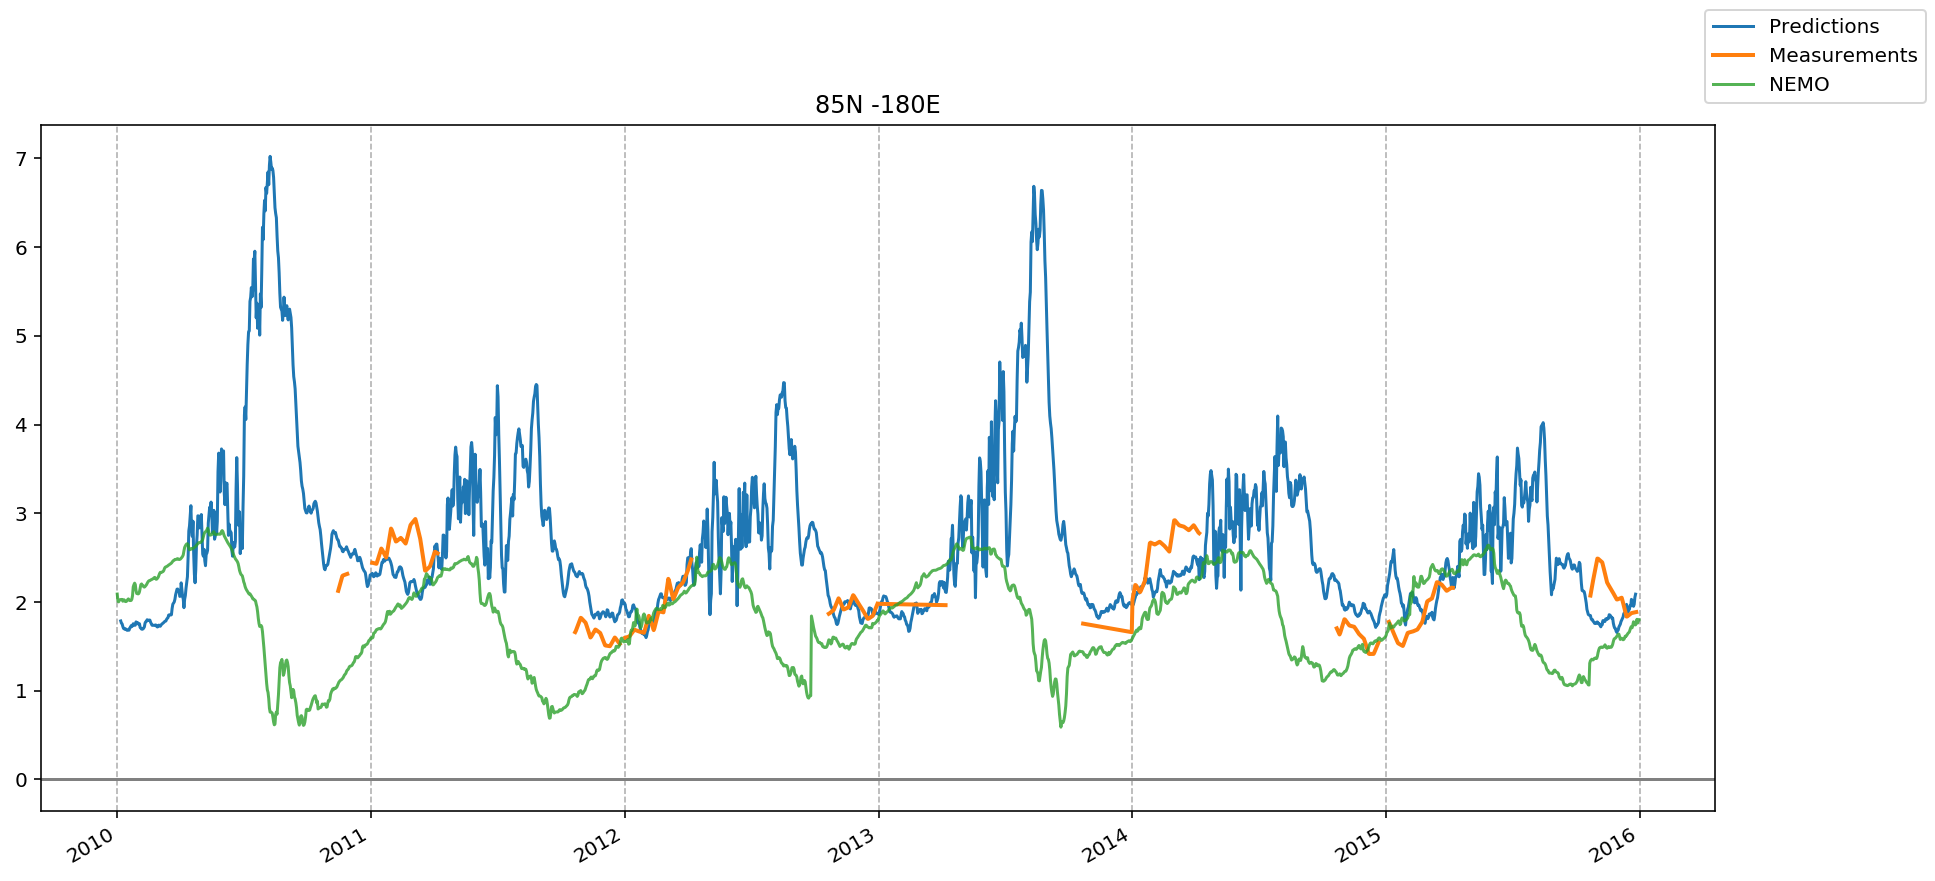

In [4]:
reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )
filters = dict(pca='auto',
               #partial_pca=10
               )

for point in points:
    regress(point, parameters, reg_params, filters)

filters = dict(#pca=10,
               partial_pca=10,
                filter_type='gaussian',
                filter_window = 7
               )

2019-08-01 13:17:34	Loading test and train data...
2019-08-01 13:17:58	Data is loaded
Applying partial PCA
Applying partial PCA
Using 70 features
RMSE model-measurements: 0.37833
RMSE prediction-measurements: 0.18156


2019-08-01 13:18:02	Loading test and train data...
2019-08-01 13:18:25	Data is loaded
Applying partial PCA
Applying partial PCA
Using 70 features
RMSE model-measurements: 1.07631
RMSE prediction-measurements: 0.39179


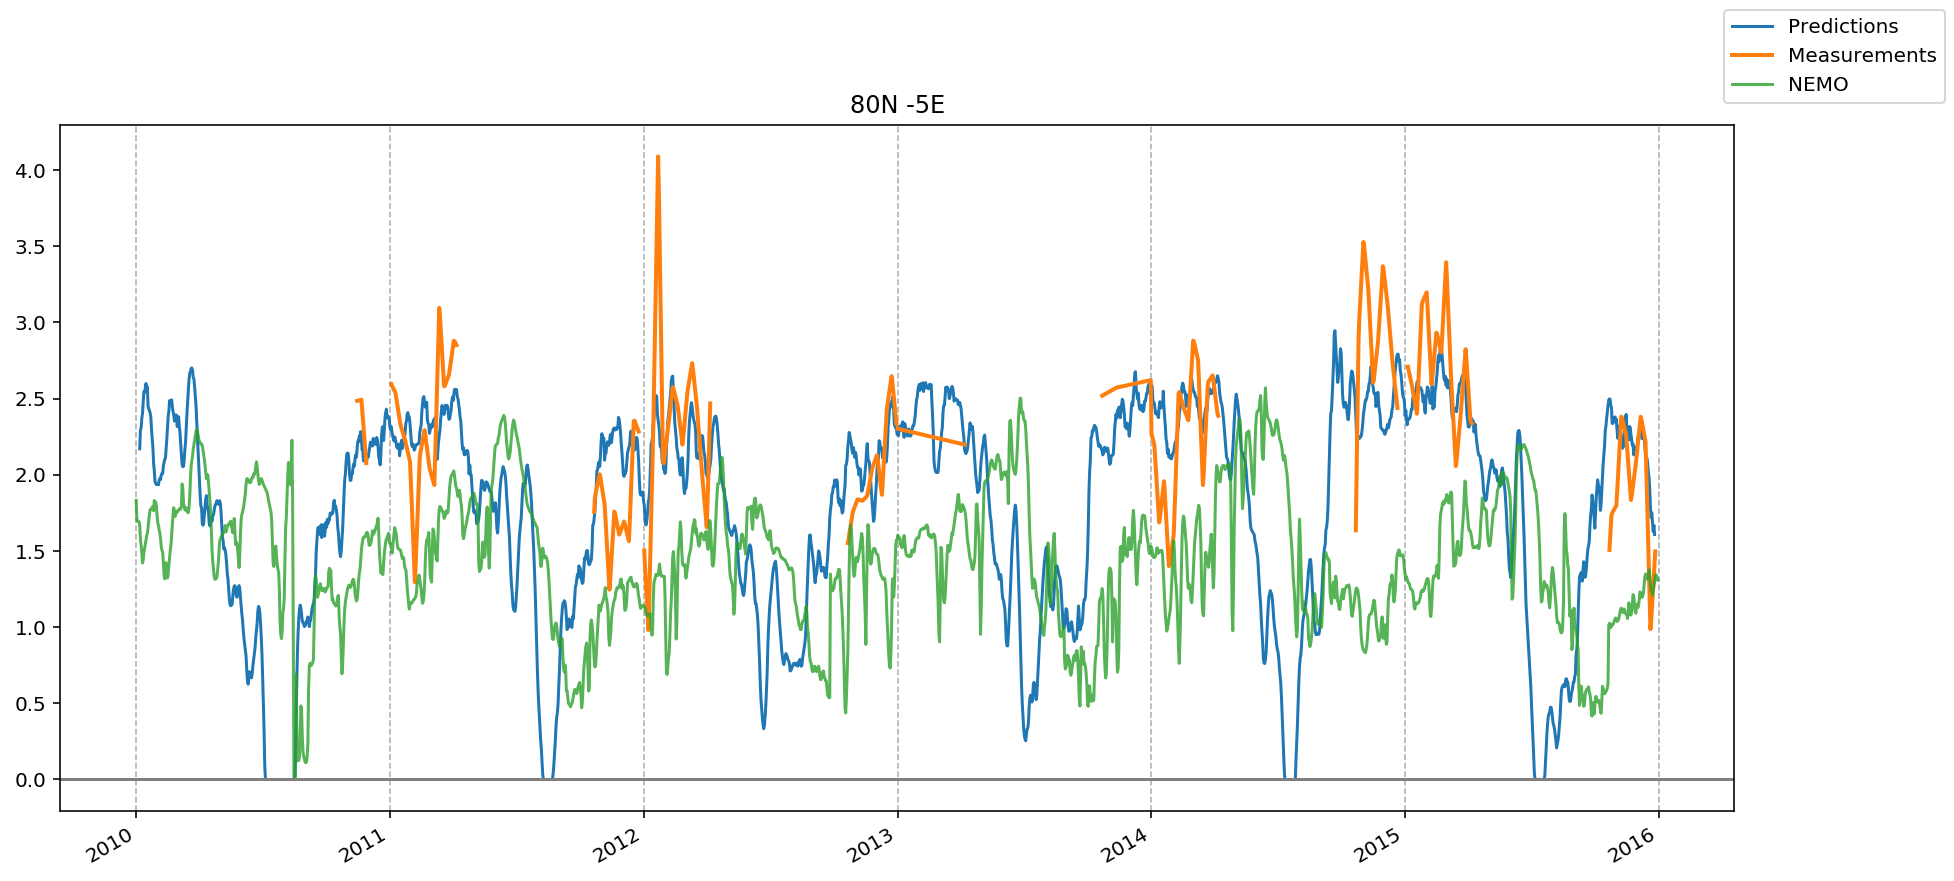

2019-08-01 13:18:29	Loading test and train data...
2019-08-01 13:18:53	Data is loaded
Applying partial PCA
Applying partial PCA
Using 70 features
RMSE model-measurements: 0.46572
RMSE prediction-measurements: 0.25399


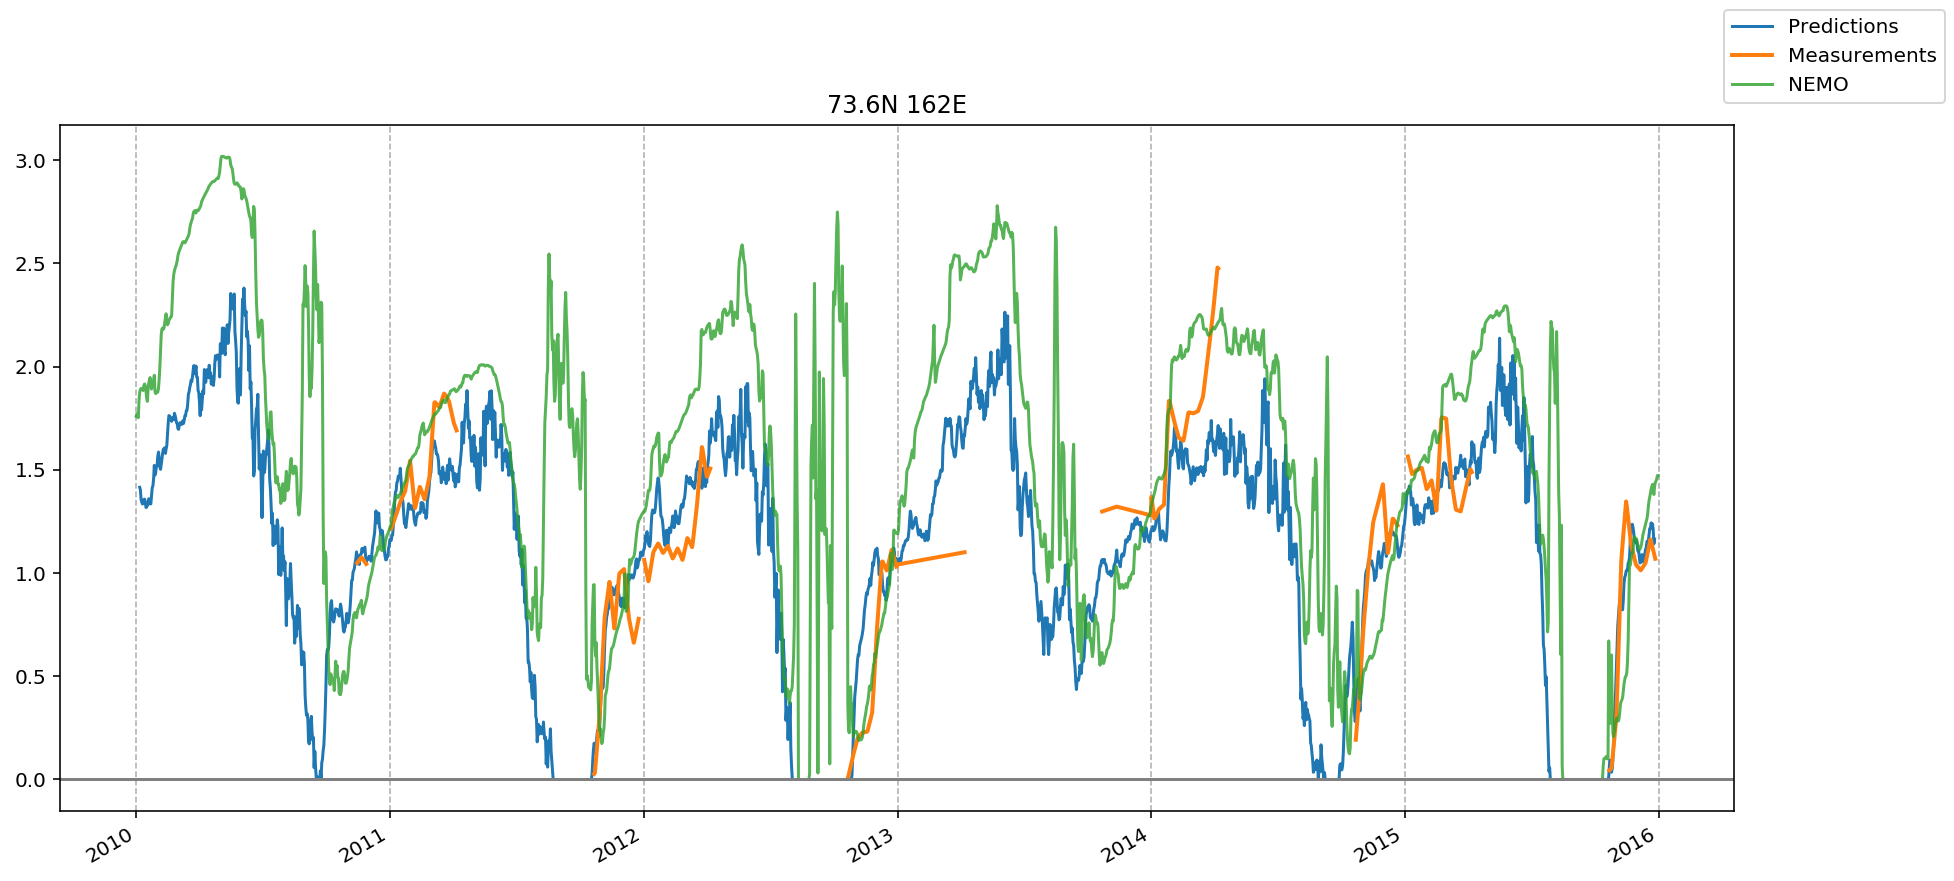

2019-08-01 13:18:57	Loading test and train data...
2019-08-01 13:19:21	Data is loaded
Applying partial PCA
Applying partial PCA
Using 70 features
RMSE model-measurements: 0.46759
RMSE prediction-measurements: 0.24392


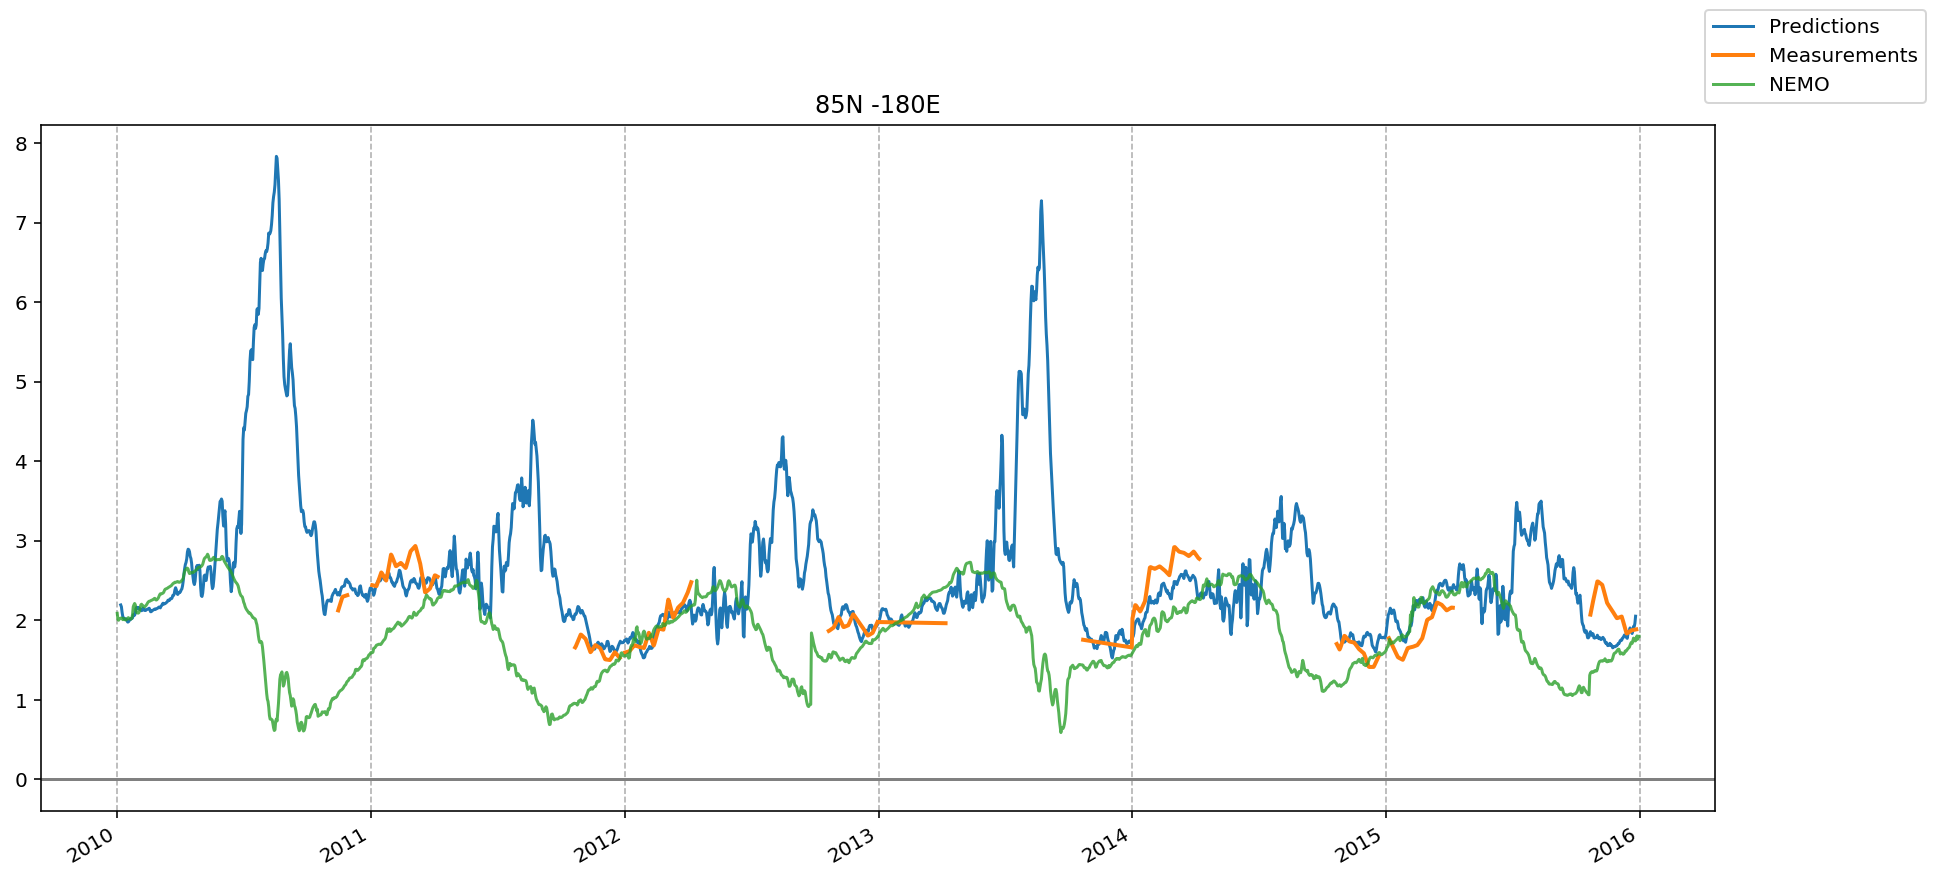

In [5]:
parameters = dict(years_train=list(range(2010, 2016)),
                  years_test=list(range(2010, 2016)),
                  #X_vars=['ice_conc', 'tair', 'votemper','vosaline','radlw','radsw'],
                  X_vars=['ice_conc','icethic_cea', 'votemper','vosaline','radlw','radsw','tair'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )

filters = dict(#pca=10,
               partial_pca=10,
                #filter_type='gaussian',
                #filter_window = 7
               )

for point in points:
    regress(point, parameters, reg_params, filters)

2019-08-01 13:19:25	Loading test and train data...
2019-08-01 13:19:48	Data is loaded
Applying partial PCA
Applying gaussian filter
Applying partial PCA
Applying gaussian filter
Using 70 features
RMSE model-measurements: 0.37833
RMSE prediction-measurements: 0.15831


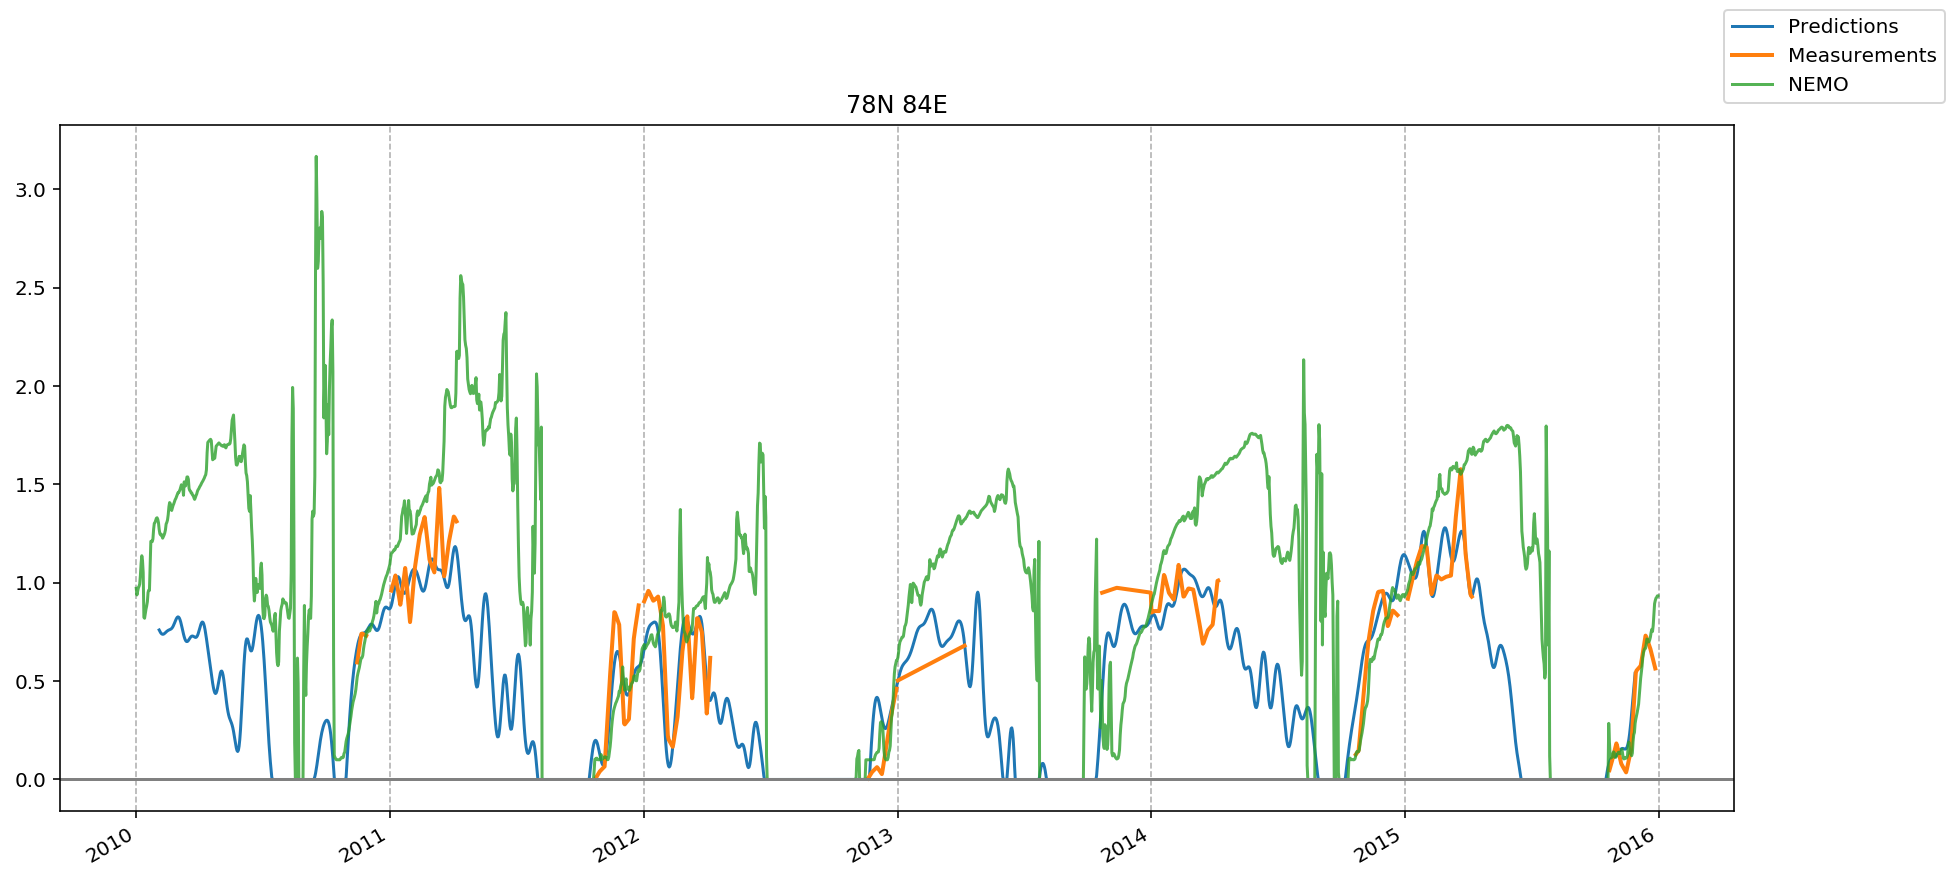

2019-08-01 13:19:52	Loading test and train data...
2019-08-01 13:20:17	Data is loaded
Applying partial PCA
Applying gaussian filter
Applying partial PCA
Applying gaussian filter
Using 70 features
RMSE model-measurements: 1.07631
RMSE prediction-measurements: 0.35984


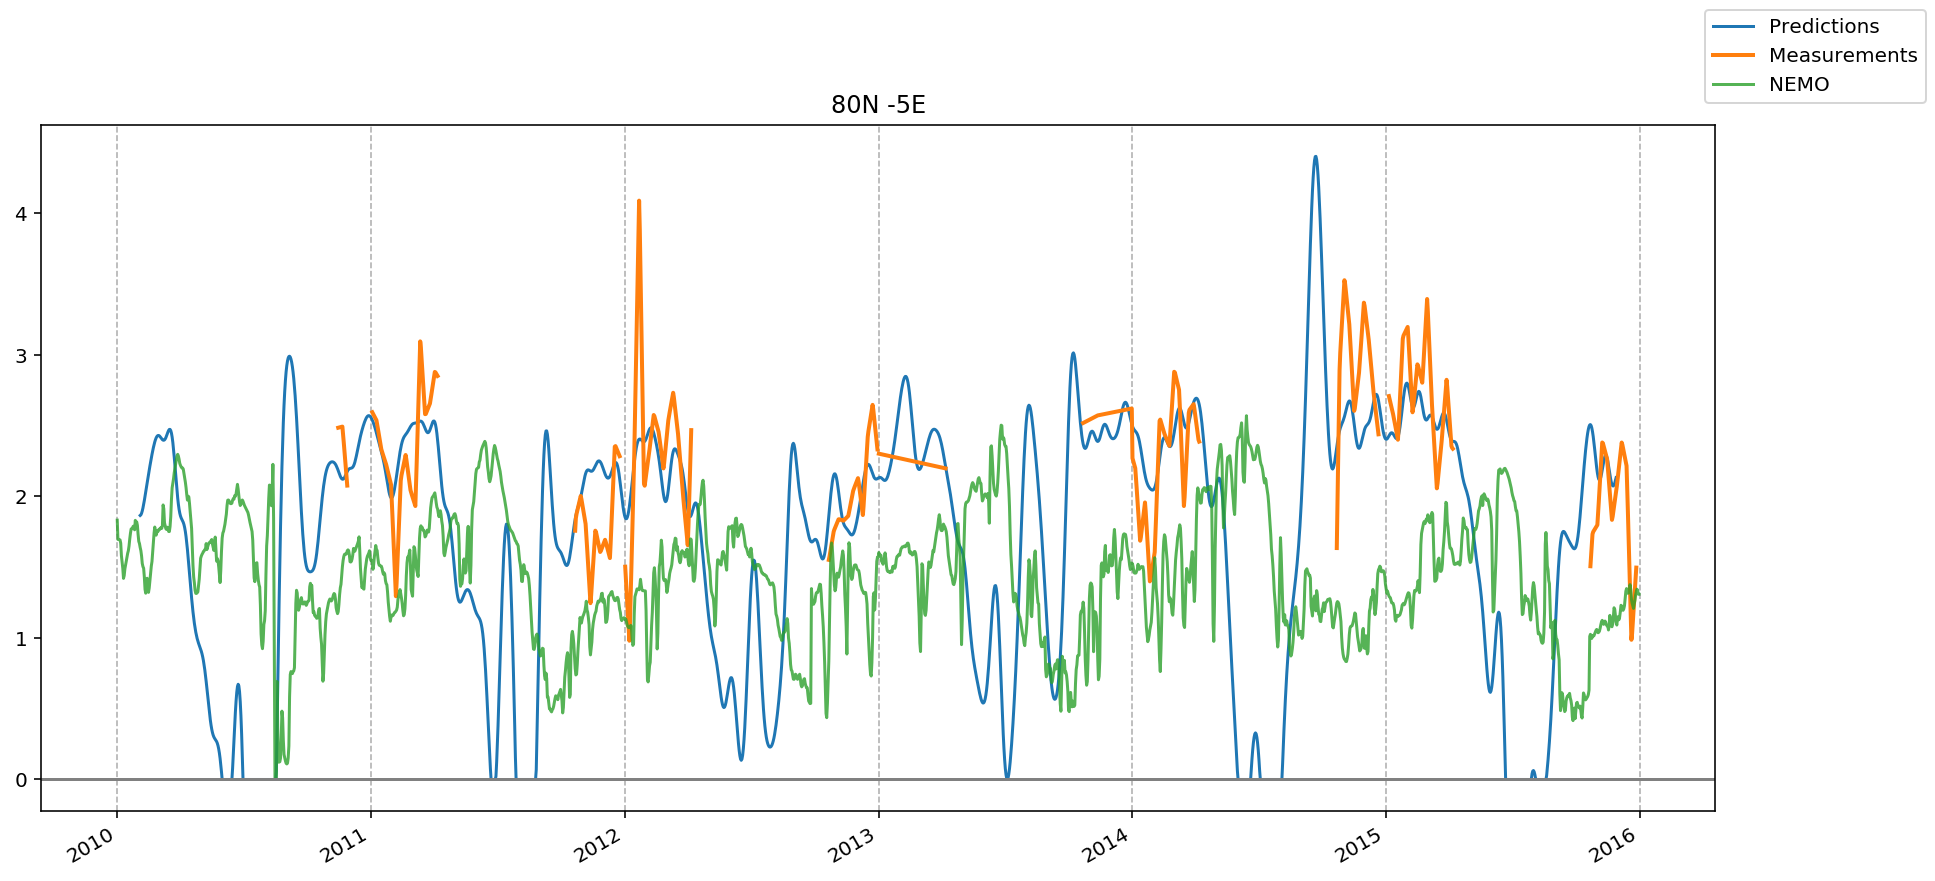

2019-08-01 13:20:21	Loading test and train data...
2019-08-01 13:20:45	Data is loaded
Applying partial PCA
Applying gaussian filter
Applying partial PCA
Applying gaussian filter
Using 70 features
RMSE model-measurements: 0.46572
RMSE prediction-measurements: 0.23097


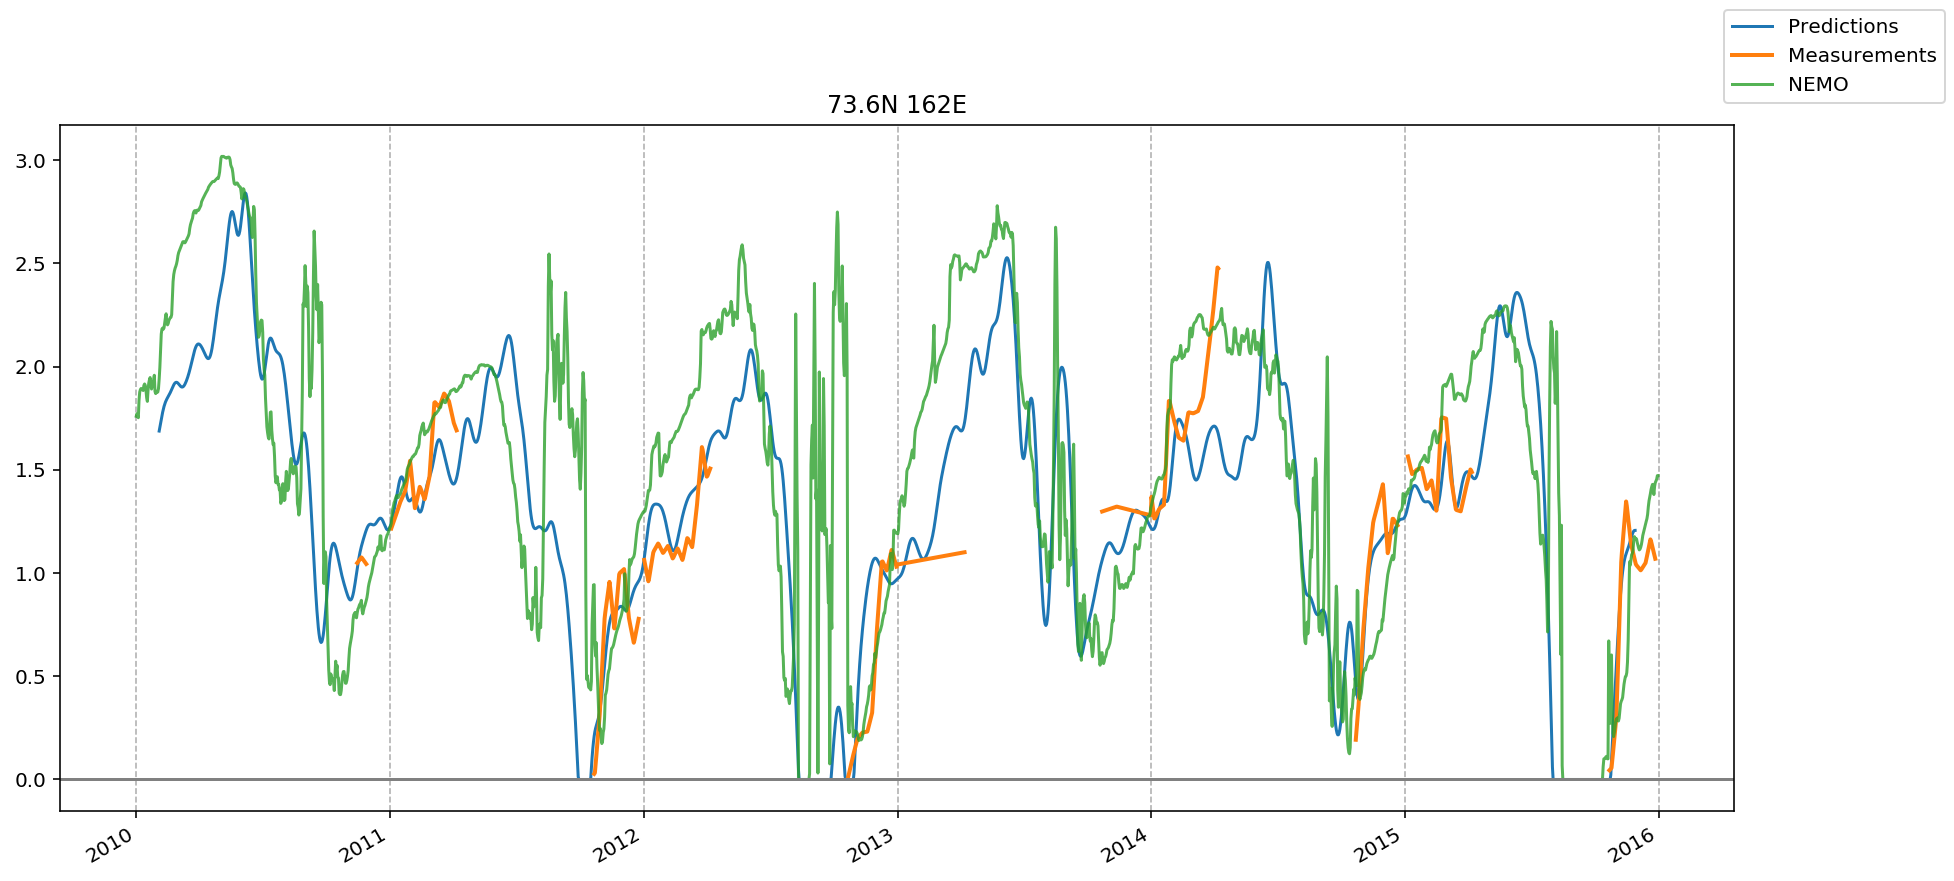

2019-08-01 13:20:49	Loading test and train data...
2019-08-01 13:21:13	Data is loaded
Applying partial PCA
Applying gaussian filter
Applying partial PCA
Applying gaussian filter
Using 70 features
RMSE model-measurements: 0.46759
RMSE prediction-measurements: 0.23128


In [6]:
parameters = dict(years_train=list(range(2010, 2016)),
                  years_test=list(range(2010, 2016)),
                  X_vars=['ice_conc','icethic_cea', 'tair', 'votemper','vosaline','radlw','radsw'],
                  #X_vars=['ice_conc','icethic_cea', 'votemper','vosaline'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )
filters = dict(#pca=10,
               partial_pca=10,
                filter_type='gaussian',
                filter_window = 7
               )
for point in points:
    regress(point, parameters, reg_params, filters)

2019-08-01 13:21:17	Loading test and train data...
2019-08-01 13:21:41	Data is loaded
Applying partial PCA
Applying running_mean filter
Applying partial PCA
Applying running_mean filter
Using 70 features
RMSE model-measurements: 0.37833
RMSE prediction-measurements: 0.17679


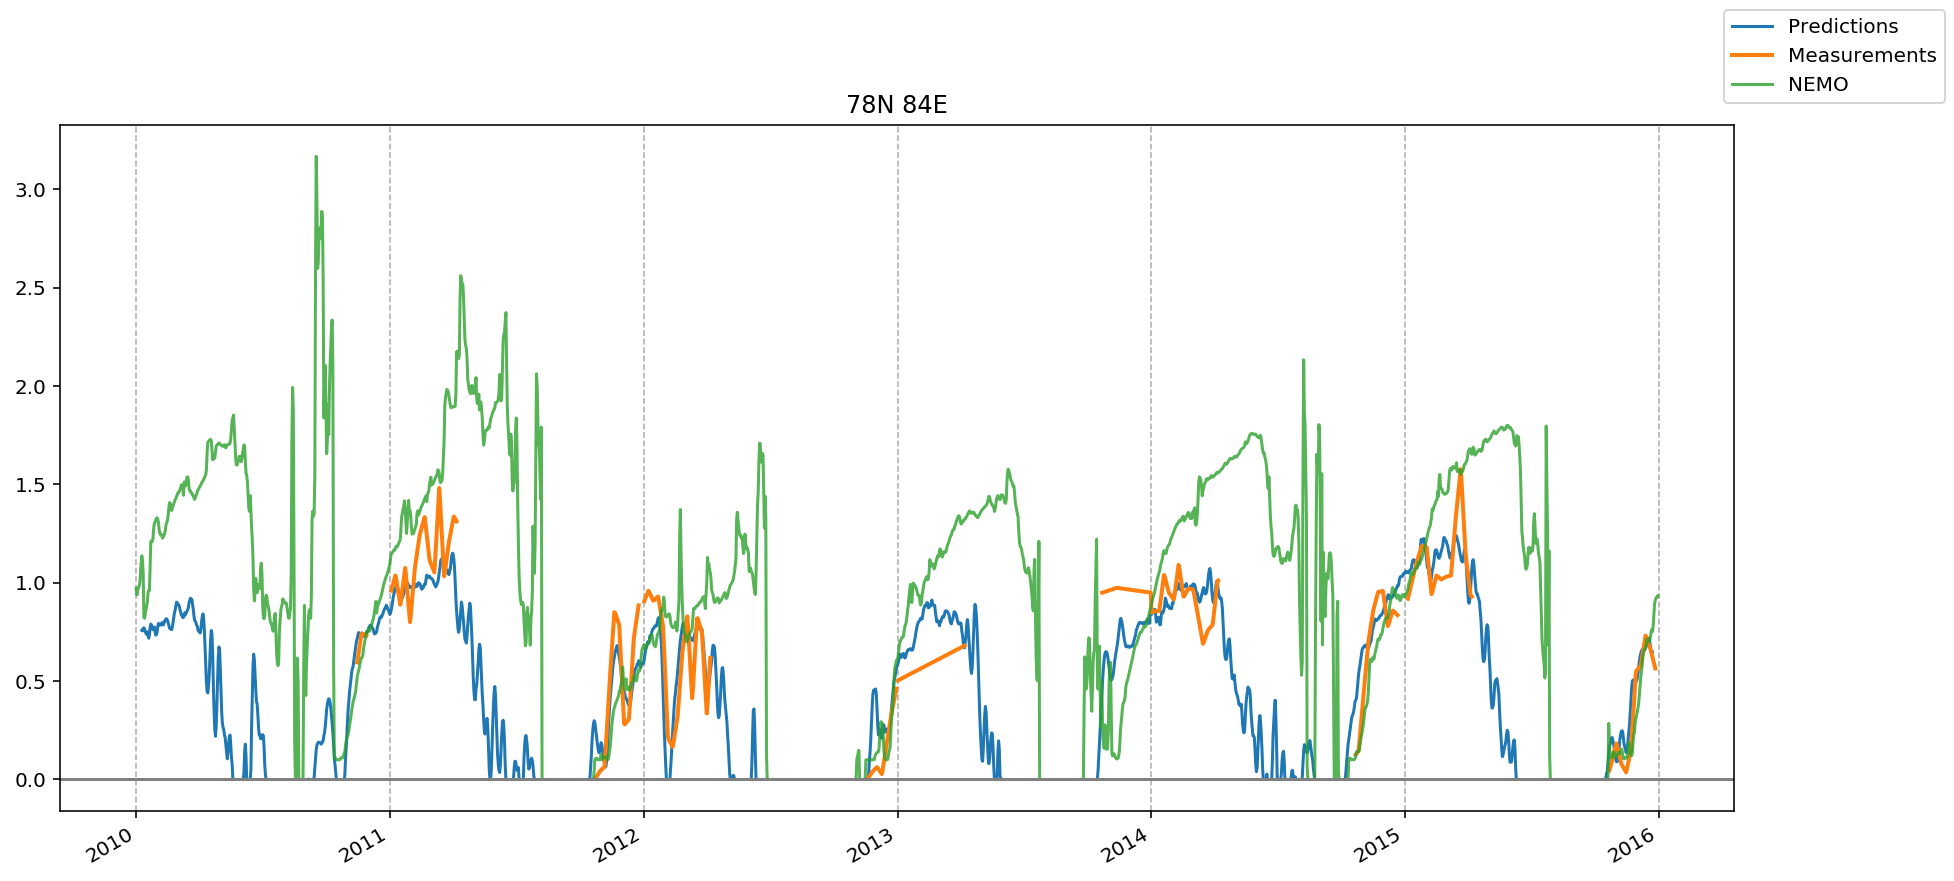

2019-08-01 13:21:45	Loading test and train data...
2019-08-01 13:22:09	Data is loaded
Applying partial PCA
Applying running_mean filter
Applying partial PCA
Applying running_mean filter
Using 70 features
RMSE model-measurements: 1.07631
RMSE prediction-measurements: 0.38582


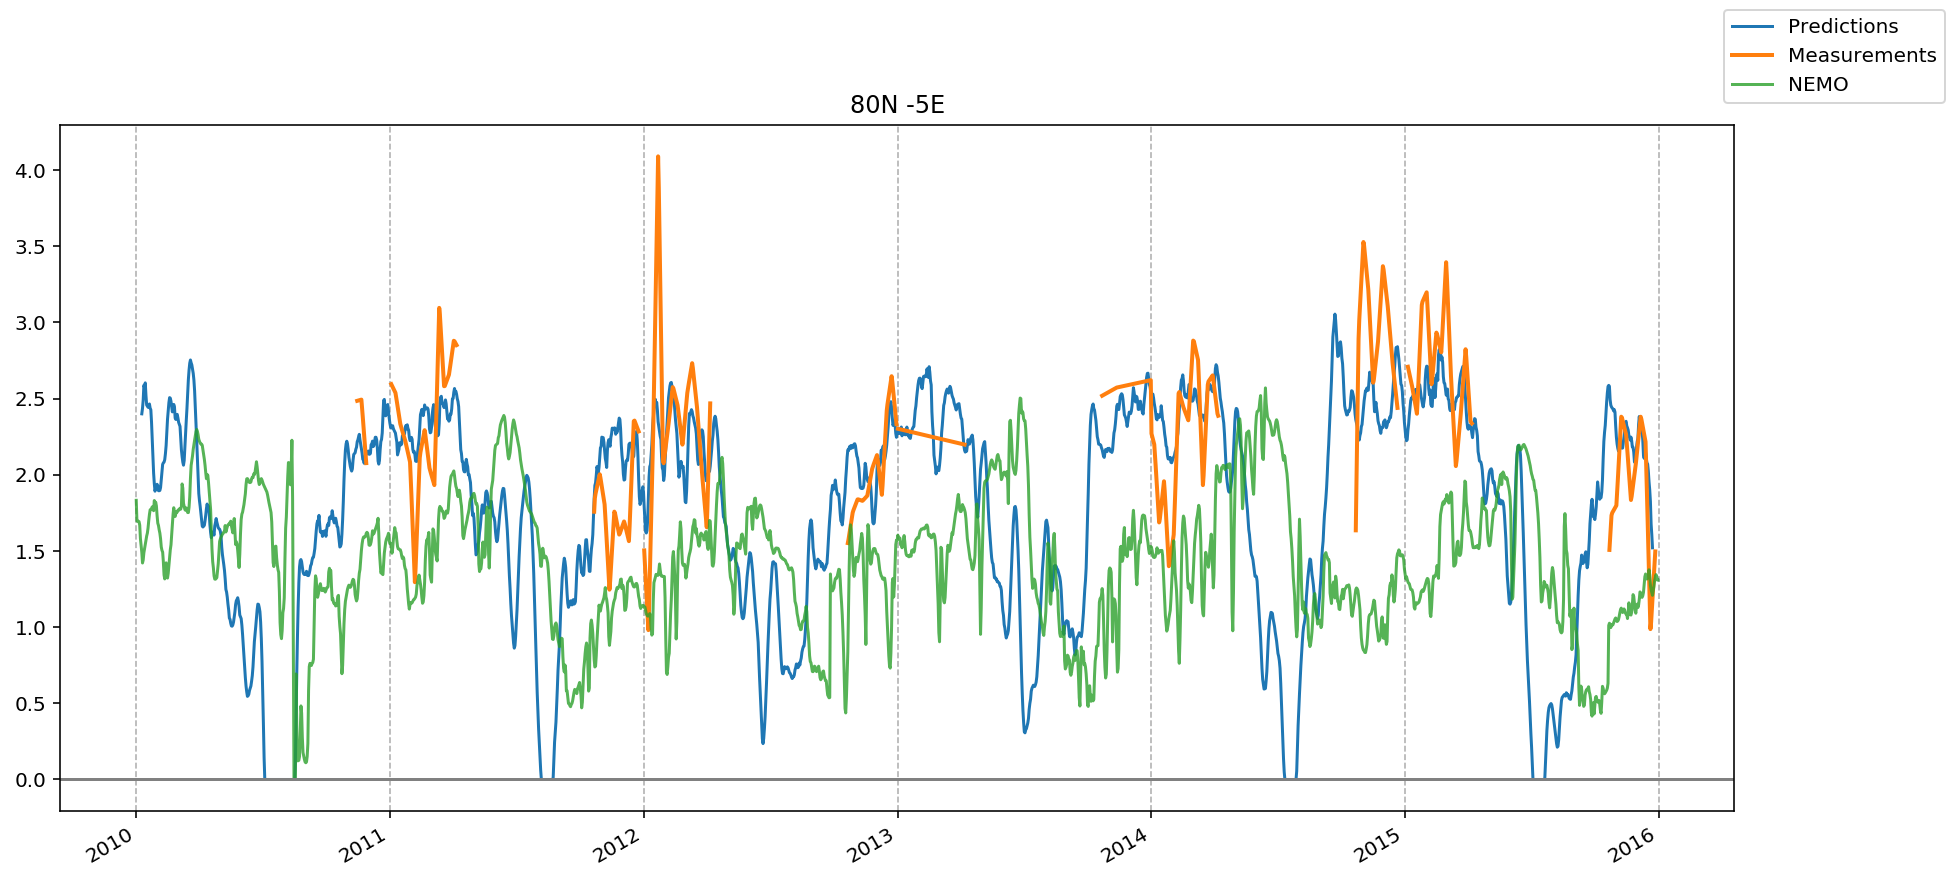

2019-08-01 13:22:13	Loading test and train data...
2019-08-01 13:22:37	Data is loaded
Applying partial PCA
Applying running_mean filter
Applying partial PCA
Applying running_mean filter
Using 70 features
RMSE model-measurements: 0.46572
RMSE prediction-measurements: 0.24846


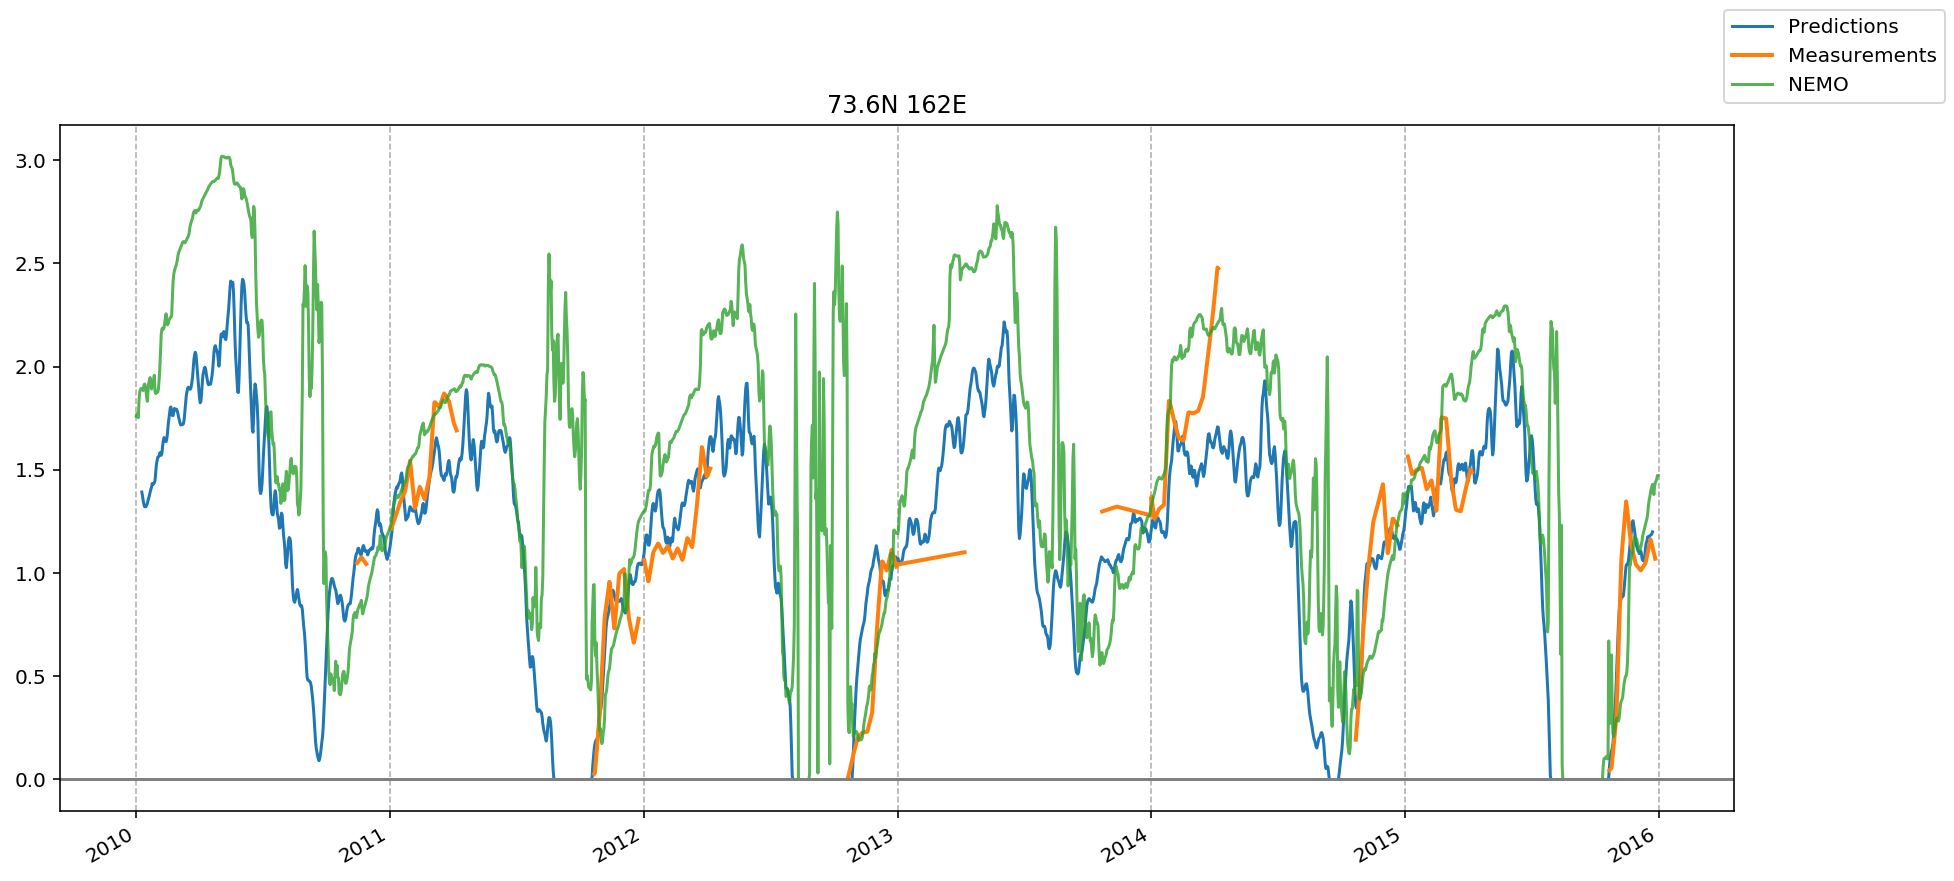

2019-08-01 13:22:41	Loading test and train data...
2019-08-01 13:23:05	Data is loaded
Applying partial PCA
Applying running_mean filter
Applying partial PCA
Applying running_mean filter
Using 70 features
RMSE model-measurements: 0.46759
RMSE prediction-measurements: 0.24093


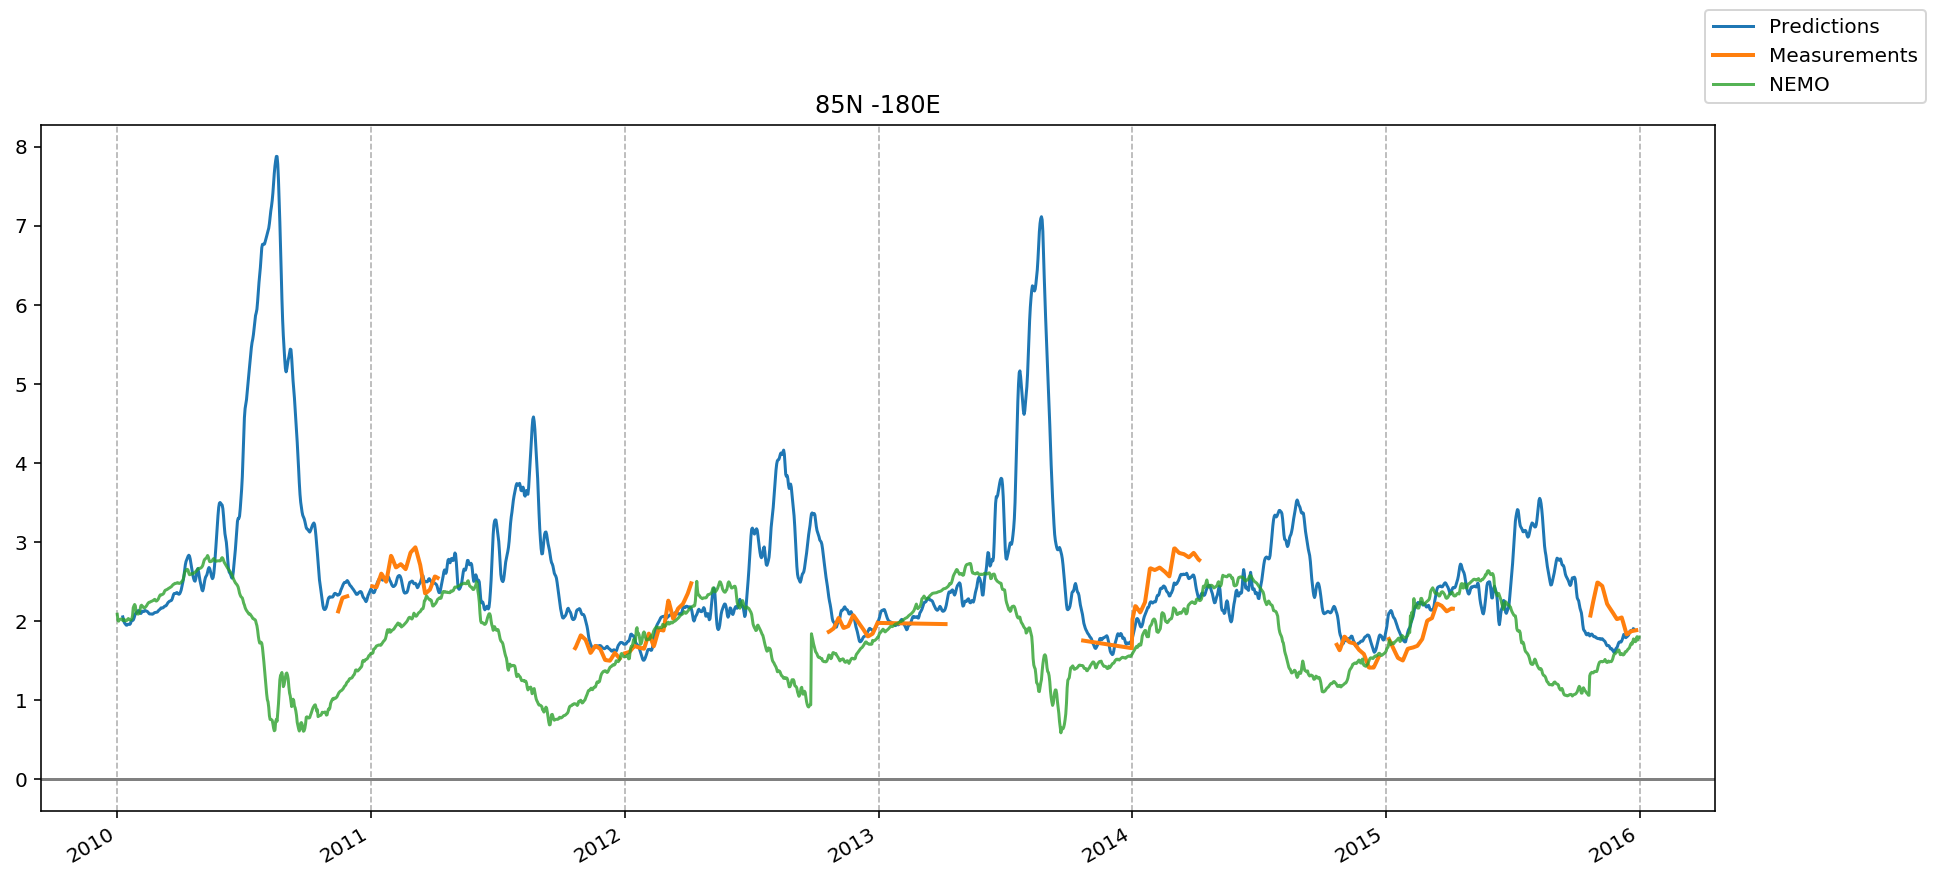

In [7]:
parameters = dict(years_train=list(range(2010, 2016)),
                  years_test=list(range(2010, 2016)),
                  X_vars=['ice_conc','icethic_cea', 'tair', 'votemper','vosaline','radlw','radsw'],
                  #X_vars=['ice_conc','icethic_cea', 'votemper','vosaline'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )
filters = dict(#pca=10,
               partial_pca=10,
                filter_type='running_mean',
                filter_window = 7
               )
for point in points:
    regress(point, parameters, reg_params, filters)

2019-08-01 13:23:09	Loading test and train data...
2019-08-01 13:23:33	Data is loaded
Applying partial PCA
Applying partial PCA
Using 35 features
RMSE model-measurements: 0.37833
RMSE prediction-measurements: 0.19573


2019-08-01 13:23:37	Loading test and train data...
2019-08-01 13:24:01	Data is loaded
Applying partial PCA
Applying partial PCA
Using 35 features
RMSE model-measurements: 1.07631
RMSE prediction-measurements: 0.39272


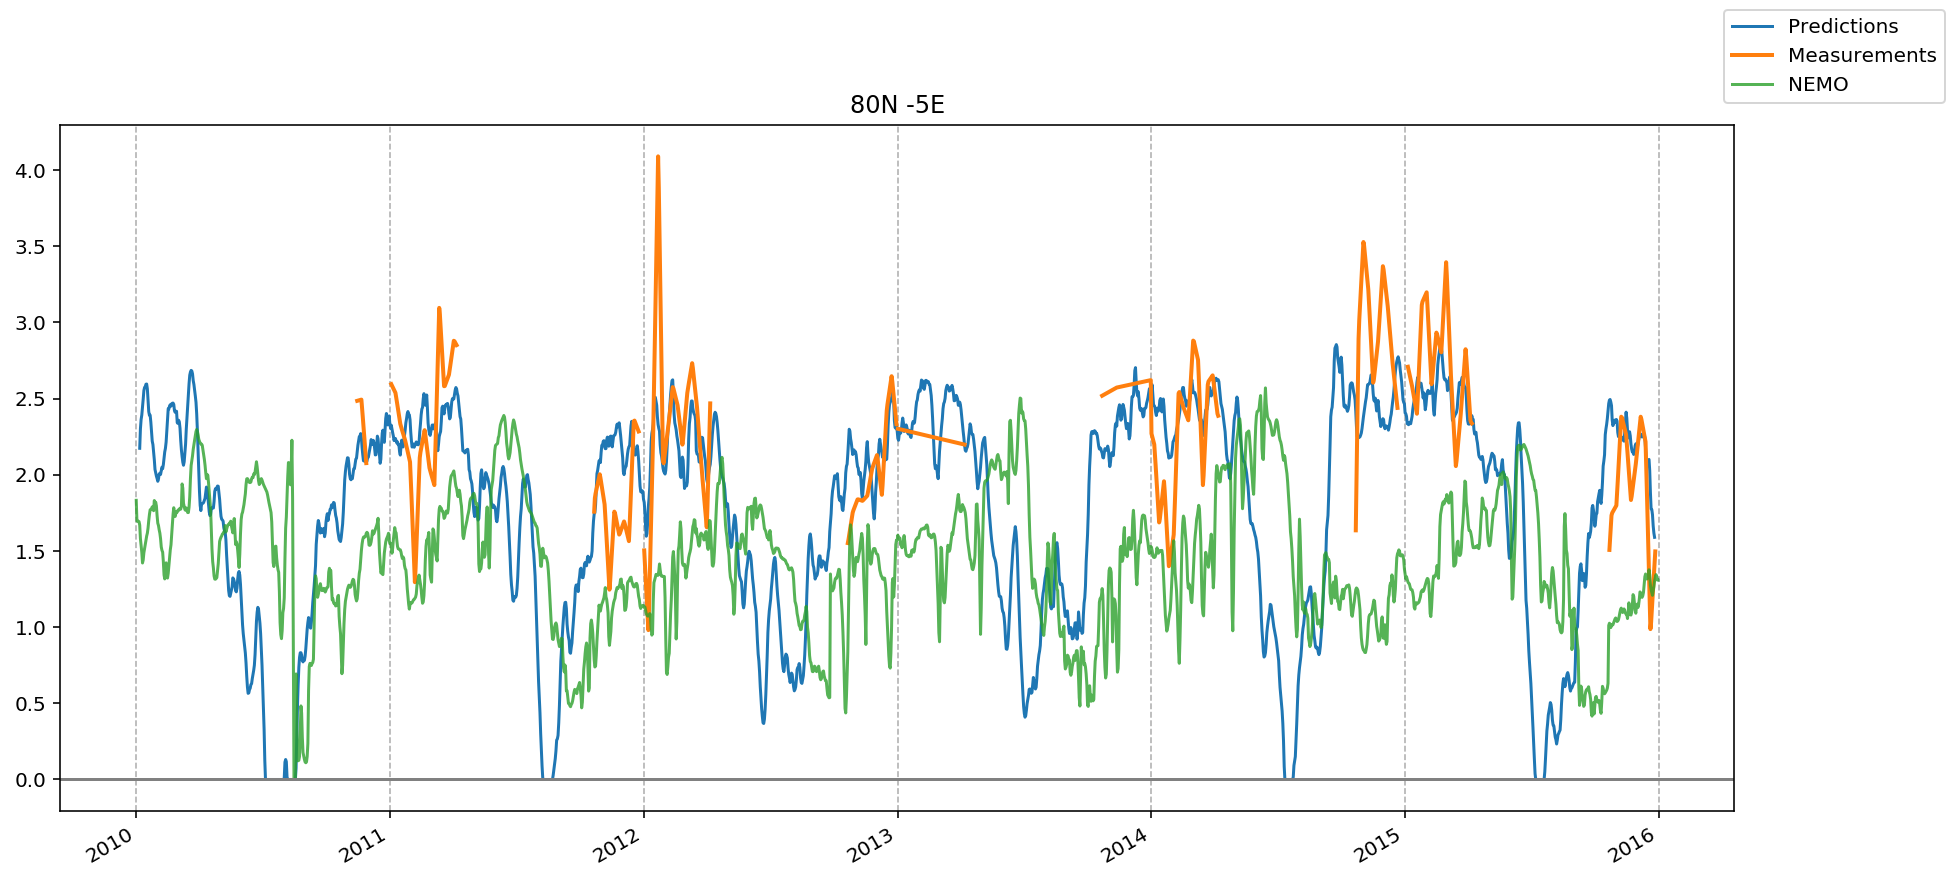

2019-08-01 13:24:05	Loading test and train data...
2019-08-01 13:24:28	Data is loaded
Applying partial PCA
Applying partial PCA
Using 35 features
RMSE model-measurements: 0.46572
RMSE prediction-measurements: 0.25585


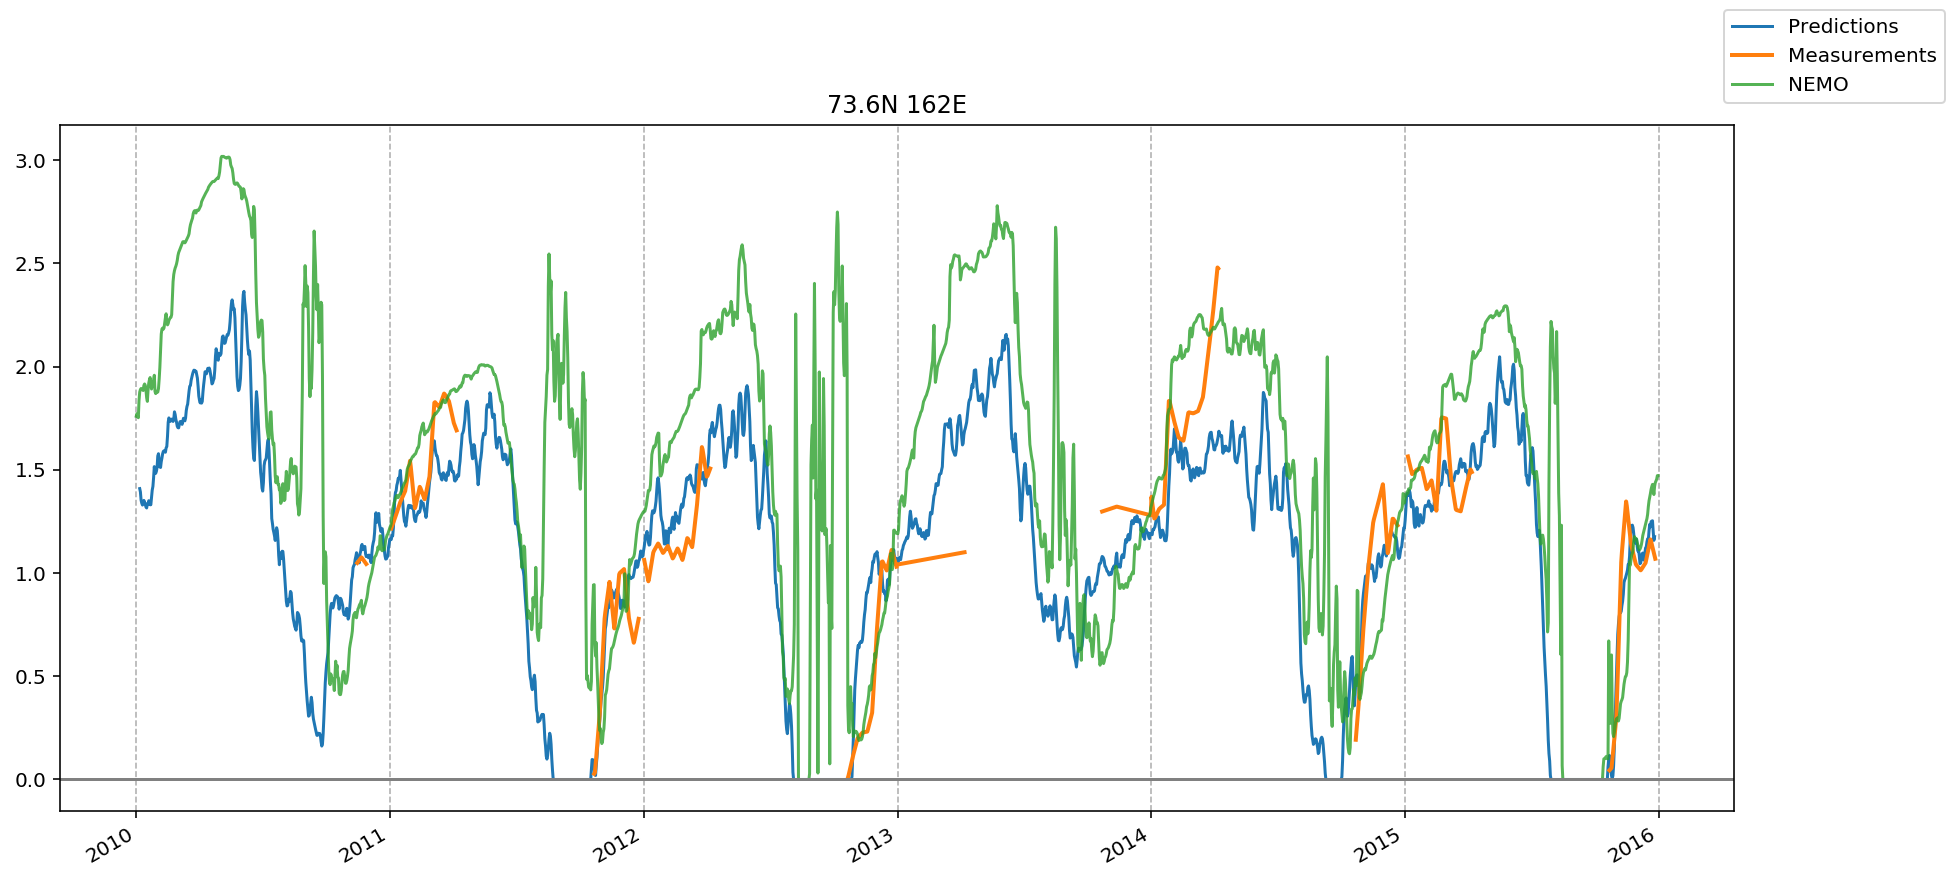

2019-08-01 13:24:32	Loading test and train data...
2019-08-01 13:24:56	Data is loaded
Applying partial PCA
Applying partial PCA
Using 35 features
RMSE model-measurements: 0.46759
RMSE prediction-measurements: 0.24512


In [8]:
parameters = dict(years_train=list(range(2010, 2016)),
                  years_test=list(range(2010, 2016)),
                  #X_vars=['ice_conc', 'tair', 'votemper','vosaline','radlw','radsw'],
                  X_vars=['ice_conc','icethic_cea', 'votemper','vosaline','radlw','radsw','tair'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )

filters = dict(#pca=10,
               partial_pca=5,
                #filter_type='gaussian',
                #filter_window = 7
               )

for point in points:
    regress(point, parameters, reg_params, filters)

2019-08-01 13:29:24	Loading test and train data...
2019-08-01 13:29:47	Data is loaded
Applying running_mean filter
Applying running_mean filter
Using 9317 features


/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE model-measurements: 0.37833
RMSE prediction-measurements: 0.19339


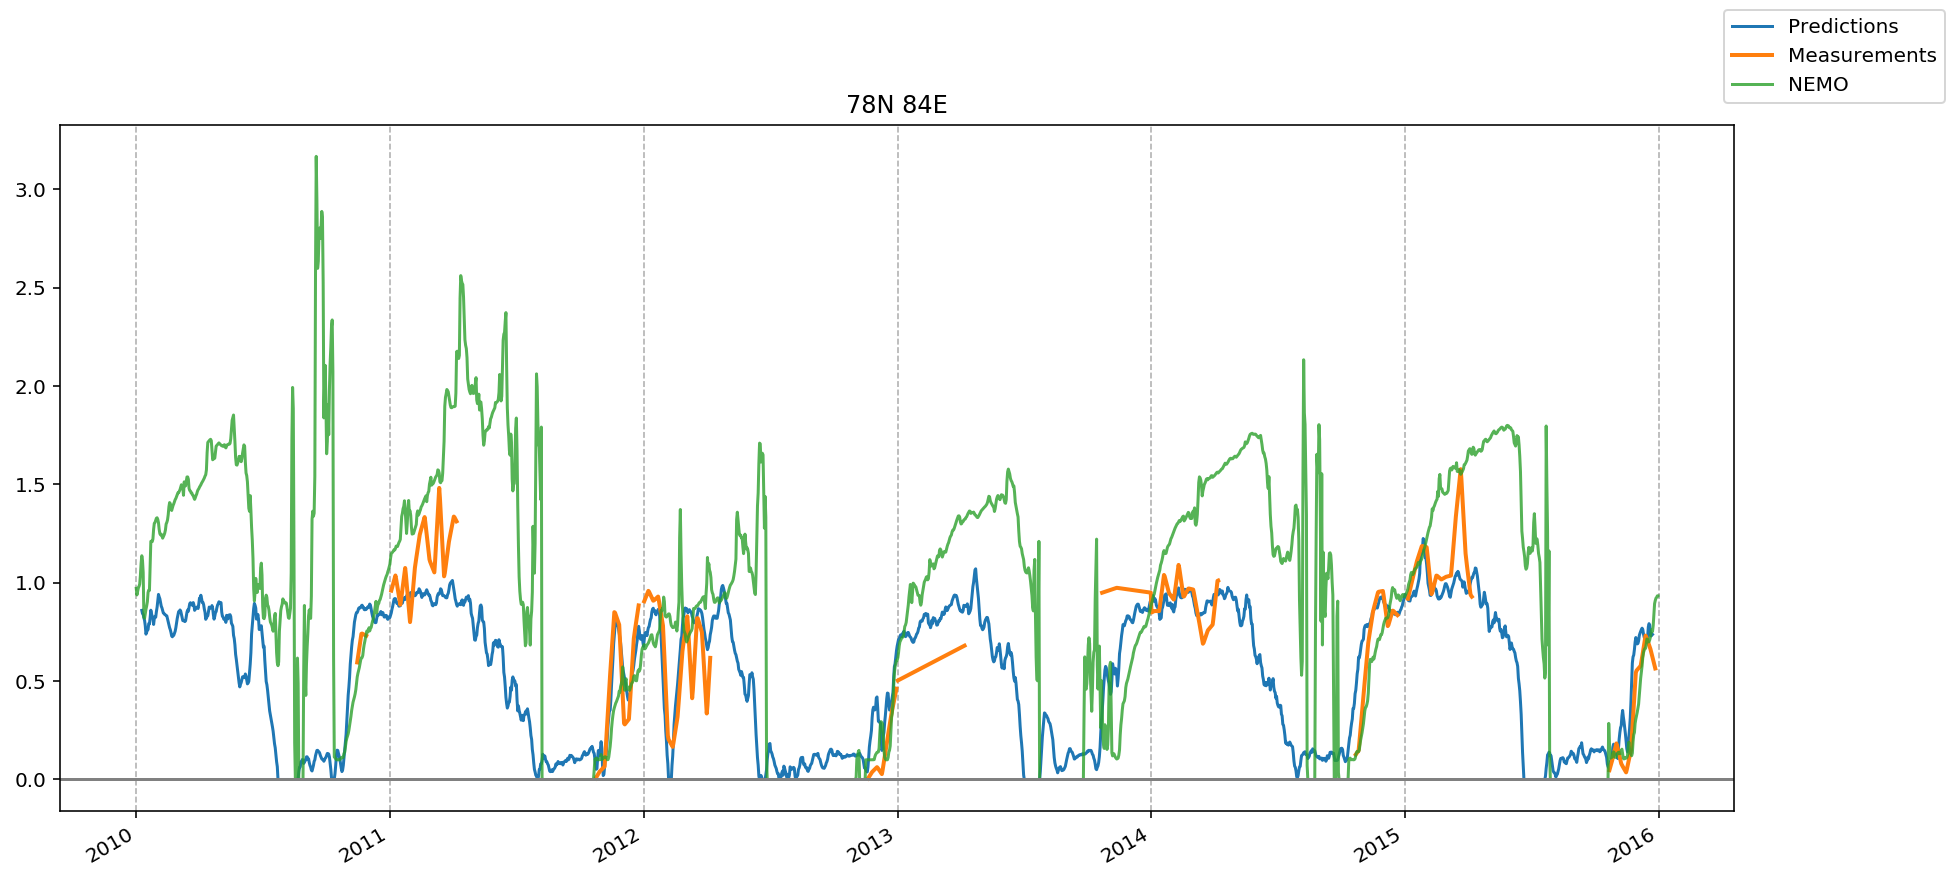

2019-08-01 13:30:02	Loading test and train data...
2019-08-01 13:30:25	Data is loaded
Applying running_mean filter
Applying running_mean filter
Using 9317 features


/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE model-measurements: 1.07631
RMSE prediction-measurements: 0.37213


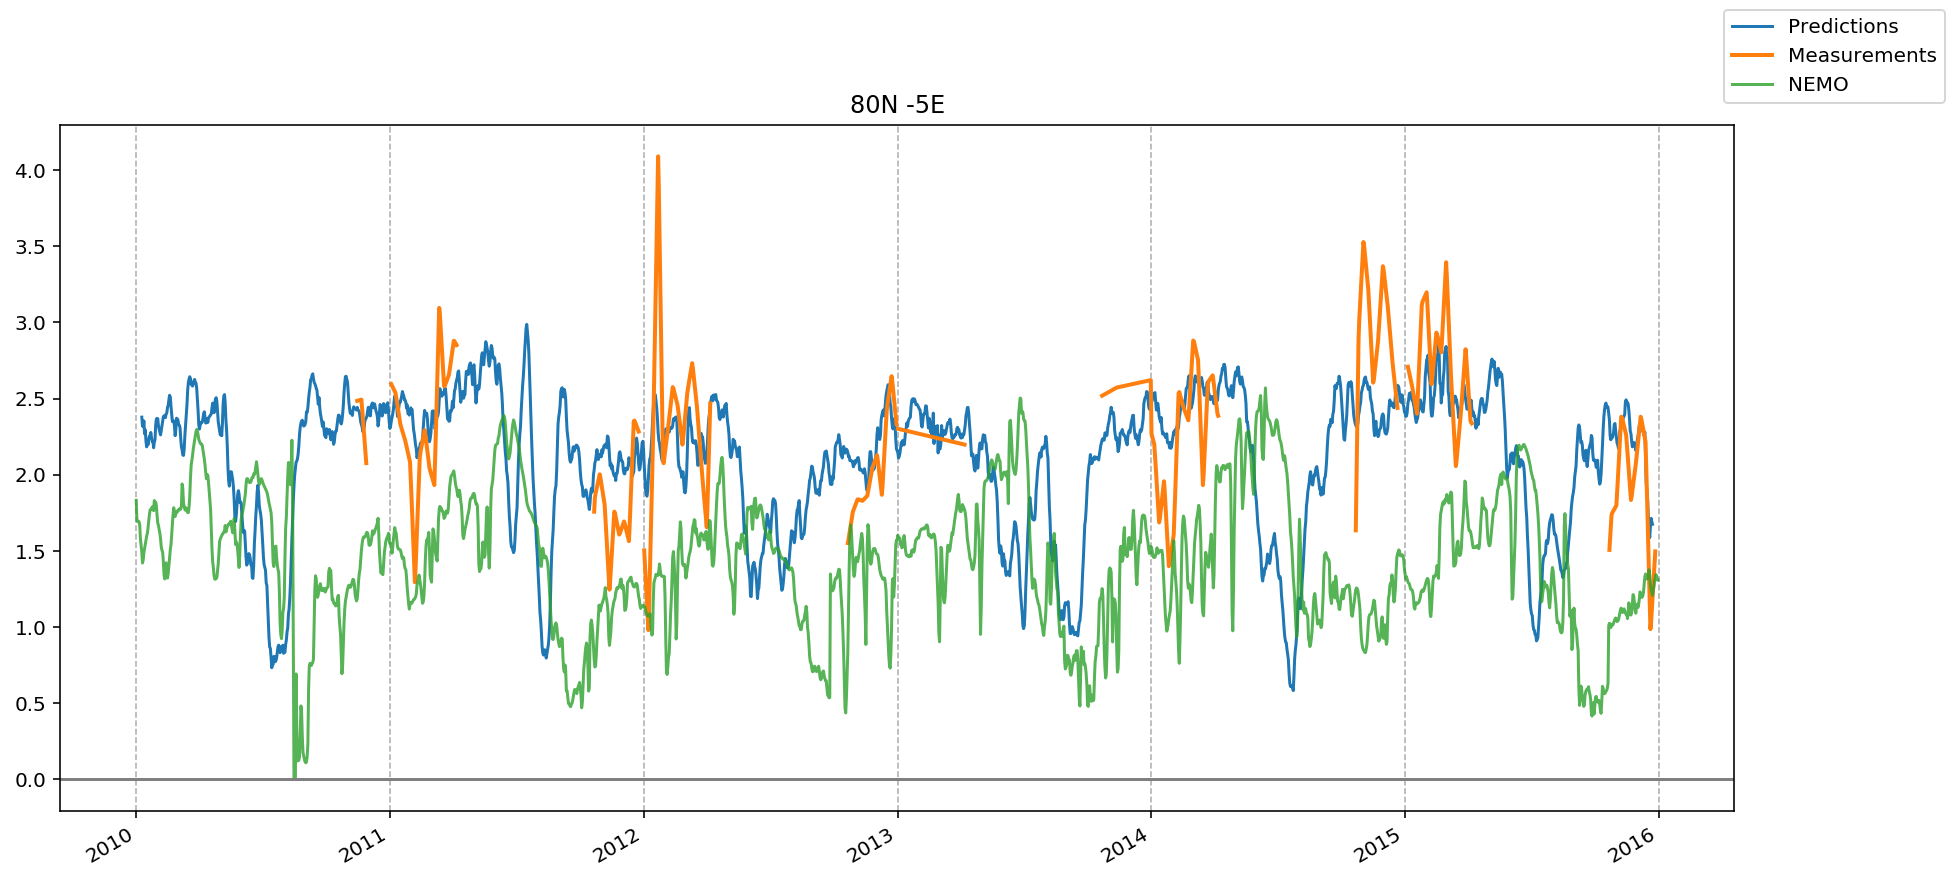

2019-08-01 13:30:39	Loading test and train data...
2019-08-01 13:31:04	Data is loaded
Applying running_mean filter
Applying running_mean filter
Using 9317 features


/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE model-measurements: 0.46572
RMSE prediction-measurements: 0.28051


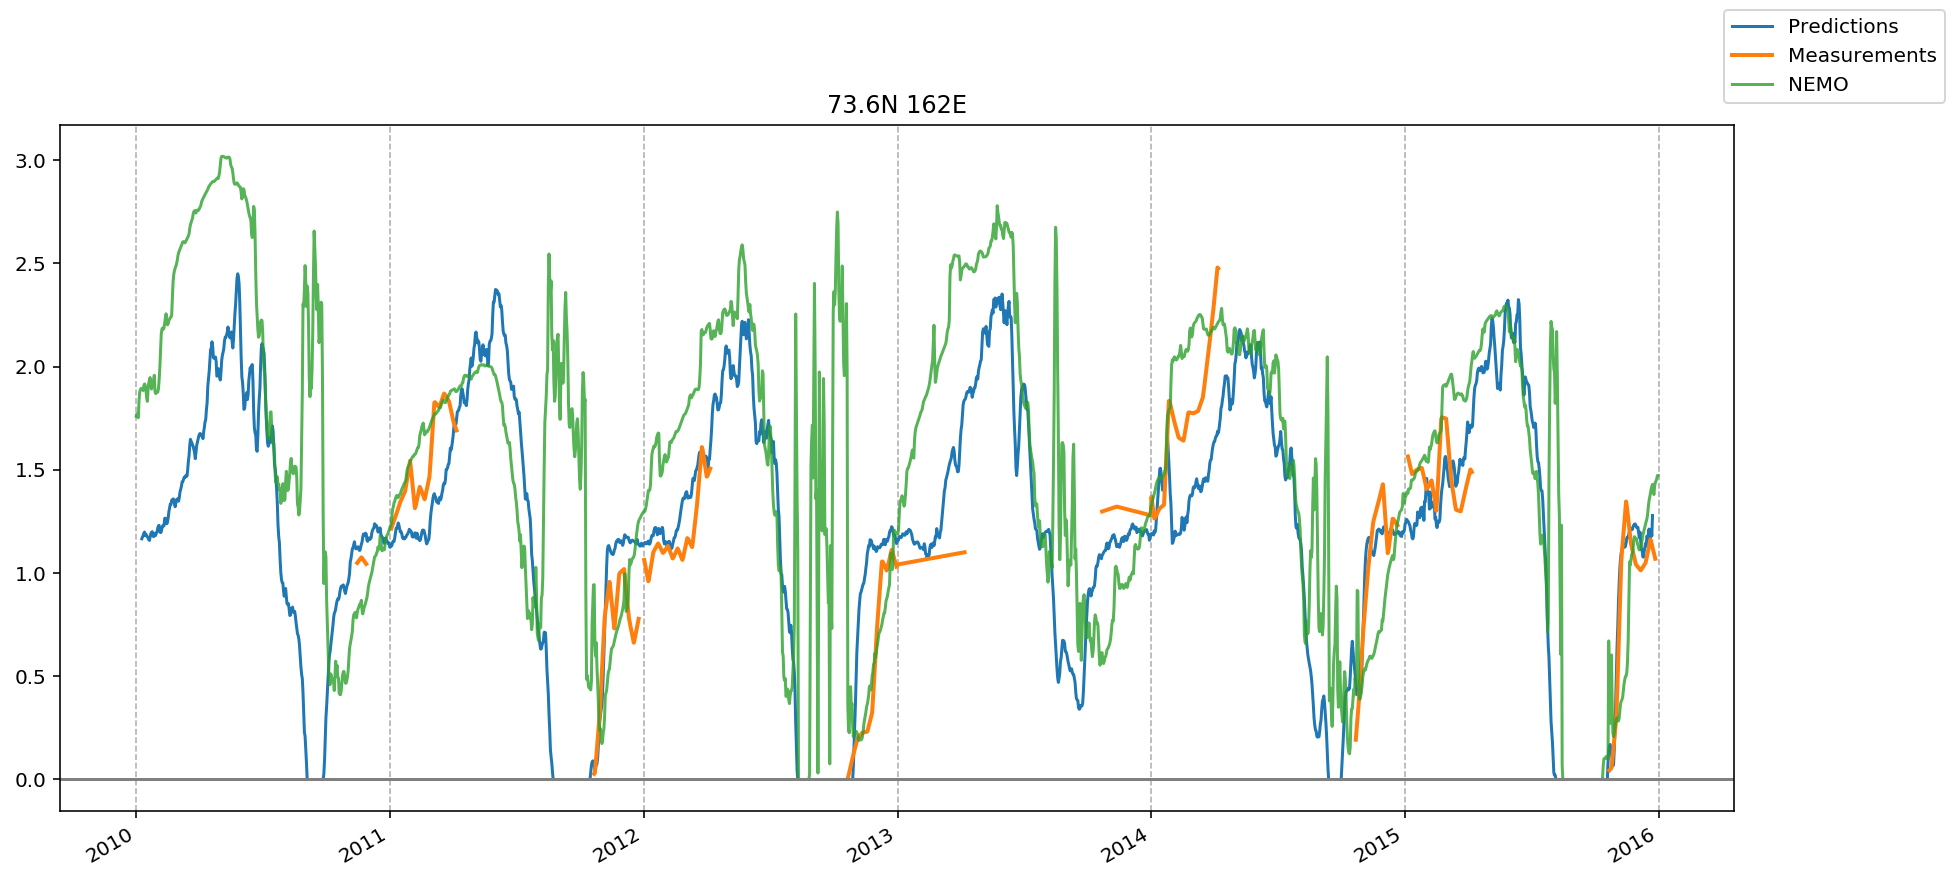

2019-08-01 13:31:18	Loading test and train data...
2019-08-01 13:31:42	Data is loaded
Applying running_mean filter
Applying running_mean filter
Using 9317 features


/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE model-measurements: 0.46759
RMSE prediction-measurements: 0.27774


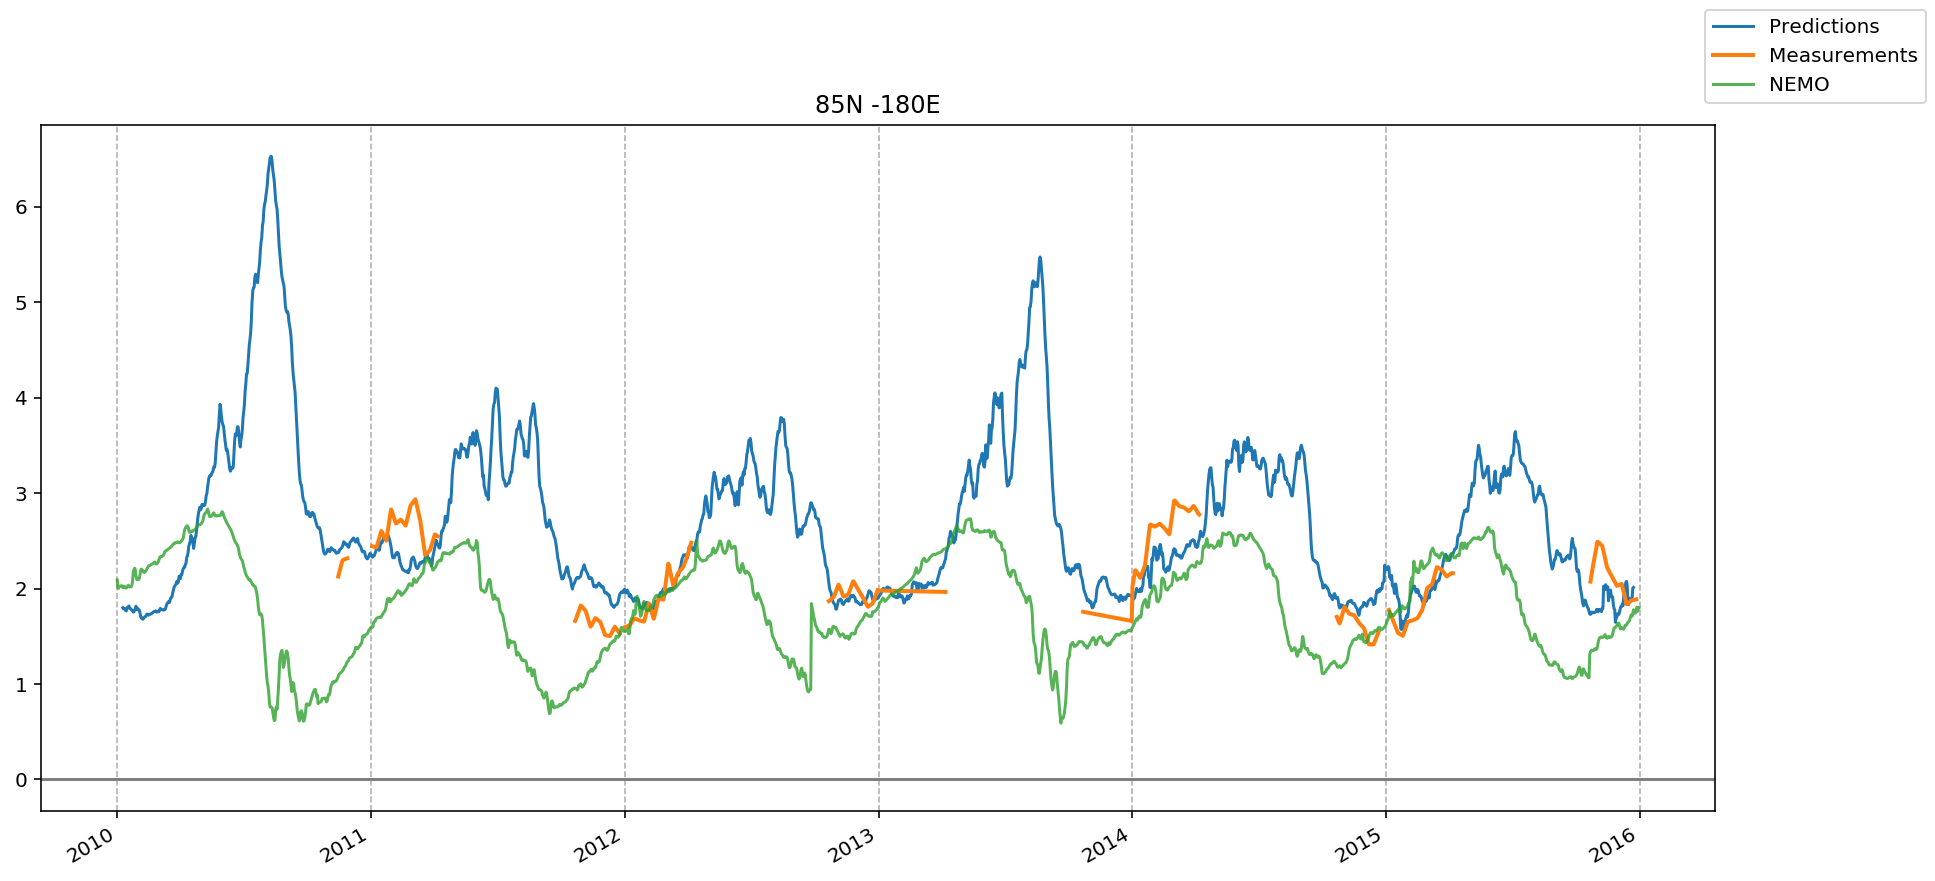

In [9]:
parameters = dict(years_train=list(range(2010, 2016)),
                  years_test=list(range(2010, 2016)),
                  #X_vars=['ice_conc', 'tair', 'votemper','vosaline','radlw','radsw'],
                  X_vars=['ice_conc','icethic_cea', 'votemper','vosaline','radlw','radsw','tair'],
                  y_var='thick_cr2smos',
                  bounds=[0, 400, 0, 400],
                  step=[1, 1]
                  )

reg_params = dict(model=Lasso(alpha=0.1),
                  dx=5,
                  dy=5,
                  dt=5
                  )

filters = dict(#pca=10,
               #partial_pca=5,
                filter_type='running_mean',
                filter_window = 7
               )

for point in points:
    regress(point, parameters, reg_params, filters)